## Preprocessing 

In [ ]:
import mne
import pandas as pd
import numpy as np
import os
from scipy.signal import butter, filtfilt

eeg_channels = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 
                'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2']

def butter_bandpass_filter(data, lowcut=0.5, highcut=50, fs=256, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1)

def extract_segments(raw_data, start_time, end_time, fs, segment_duration):
    segments = []
    start_sample = int(start_time * fs)
    end_sample = int(end_time * fs)
    
    for seg_start in range(start_sample, end_sample, segment_duration * fs):  
        seg_end = seg_start + (segment_duration * fs)
        if seg_end <= raw_data.shape[1]:
            segments.append(raw_data[:, seg_start:seg_end])  
    return segments

def process_edf(edf_path, annotation_path, participant_name, slider_values, fs=256, segment_duration=3):
    raw = mne.io.read_raw_edf(edf_path, preload=True)
    raw.pick_channels(eeg_channels)
    data = raw.get_data()
    data = butter_bandpass_filter(data, lowcut=0.5, highcut=50, fs=fs)
    data *= 1e6

    annotations = pd.read_csv(annotation_path)
    segments = []
    labels = []

    for (start_label, end_label, slider_col, segment_label) in [
        ("T1 Learning Start", "T1 Learning End", "slider_40", "T1"),
        ("T2 Learning Start", "T2 Learning End", "slider_41", "T2"),
        ("T3 Learning Start", "T3 Learning End", "slider_42", "T3"),
    ]:
        try:
            start_time = annotations.loc[annotations["Name"] == start_label, "latency"].values[0]
            end_time = annotations.loc[annotations["Name"] == end_label, "latency"].values[0]
            label_value = slider_values.loc[slider_values["Name"] == participant_name, slider_col].values[0]
            segment_data_list = extract_segments(data, start_time, end_time, fs, segment_duration)

            for segment_data in segment_data_list:
                segment_flattened = segment_data.flatten()
                segments.append(segment_flattened)
                labels.append(label_value)

        except IndexError:
            print(f"Missing annotation for {participant_name}, {start_label} - {end_label}")

    return pd.DataFrame(segments), pd.Series(labels)

def main(edf_folder, annotation_folder, output_file):
    slider_values = pd.read_excel("cog_slider_values.xlsx")
    all_data = pd.DataFrame()

    for participant in slider_values['Name']:
        edf_path = os.path.join(edf_folder, f"{participant}.edf")
        annotation_path = os.path.join(annotation_folder, f"{participant}.csv")

        if not os.path.exists(edf_path) or not os.path.exists(annotation_path):
            print(f"Missing file for {participant}")
            continue

        segments_df, labels_series = process_edf(edf_path, annotation_path, participant, slider_values)
        segments_df['Label'] = labels_series.values
        segments_df['Participant'] = participant

        all_data = pd.concat([all_data, segments_df], ignore_index=True)

    all_data.to_csv(output_file, index=False)
    print(f"Saved processed data to {output_file}")

main("../EDF_Files", "../excel annotations", "Cog_DataAugmented.csv")


Extracting EDF parameters from d:\FYP_NRS_SIR\EDF_Files\Prem_Ranjan.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4557999  =      0.000 ...  2278.999 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from d:\FYP_NRS_SIR\EDF_Files\Nido.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7877999  =      0.000 ...  3938.999 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from d:\FYP_NRS_SIR\EDF_Files\Anshul.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4779999  =      0.000 ...  2389.999 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Extracting EDF parameters from d:\FYP_NRS_SIR\EDF_Files\Prakathishwaran.edf...
EDF file detected
Setting channel info struct

In [ ]:
import pandas as pd

df = pd.read_csv("Cog_DataAugmented.csv")
print(df.iloc[:, -1])


0       Prem_Ranjan
1       Prem_Ranjan
2       Prem_Ranjan
3       Prem_Ranjan
4       Prem_Ranjan
           ...     
3039     Sai_Pranav
3040     Sai_Pranav
3041     Sai_Pranav
3042     Sai_Pranav
3043     Sai_Pranav
Name: Participant, Length: 3044, dtype: object


In [ ]:
import pandas as pd

df = pd.read_csv("Cog_DataAugmented.csv")
label_counts = df.iloc[:, -2].value_counts()
print(label_counts)


Label
medium    1432
high      1150
low        462
Name: count, dtype: int64


In [ ]:
import pandas as pd

df = pd.read_csv("Cog_DataAugmented.csv")
df.insert(0, "Name", df.pop("Participant"))
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.to_csv("Cog_Shuffled_DataAugmented.csv", index=False)
print("Shuffled dataset saved as Cog_Shuffled_DataAugmented.csv")


✅ Shuffled dataset saved as Cog_Shuffled_DataAugmentated.csv


## Feature Extraction

In [6]:
%pip install mne-features antropy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from scipy.signal import welch
import pywt
import antropy as ant
from mne_features.univariate import compute_hjorth_mobility, compute_hjorth_complexity

bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 50),
}

def bandpower(data, sf, band):
    low, high = band
    freqs, psd = welch(data, sf, nperseg=sf*2)
    band_power = np.trapz(psd[(freqs >= low) & (freqs <= high)], dx=np.diff(freqs).mean())
    return band_power / np.trapz(psd, dx=np.diff(freqs).mean())

def wavelet_energy(data, wavelet='db4'):
    coeffs = pywt.wavedec(data, wavelet, level=4)
    energy = [np.sum(np.abs(c)**2) for c in coeffs]
    return energy

def extract_features(segment, fs=256):
    features = {}
    for ch in range(segment.shape[0]):
        data = np.array(segment[ch], dtype=np.float64)

        features[f'Ch{ch}_Hjorth_Mobility'] = compute_hjorth_mobility(data)
        features[f'Ch{ch}_Hjorth_Complexity'] = compute_hjorth_complexity(data)

        features[f'Ch{ch}_Mean'] = np.mean(data)
        features[f'Ch{ch}_Std'] = np.std(data)
        features[f'Ch{ch}_Kurtosis'] = kurtosis(data)
        features[f'Ch{ch}_Skewness'] = skew(data)

        first_diff = np.diff(data)
        second_diff = np.diff(first_diff)
        features[f'Ch{ch}_First_Diff_Mean'] = np.mean(first_diff)
        features[f'Ch{ch}_Second_Diff_Mean'] = np.mean(second_diff)

        freqs, psd = welch(data, fs, nperseg=fs*2)
        max_power_idx = np.argmax(psd)
        features[f'Ch{ch}_Max_Power'] = psd[max_power_idx]
        features[f'Ch{ch}_Max_Power_Freq'] = freqs[max_power_idx]

        for band, freq_range in bands.items():
            features[f'Ch{ch}_RBP_{band}'] = bandpower(data, fs, freq_range)

        features[f'Ch{ch}_Higuchi_FD'] = ant.higuchi_fd(data)
        features[f'Ch{ch}_Petrosian_FD'] = ant.petrosian_fd(data)

        wavelet_feats = wavelet_energy(data)
        for i, val in enumerate(wavelet_feats):
            features[f'Ch{ch}_Wavelet_Energy_{i}'] = val

    return features

def process_segments(input_file, output_file, n_channels=19):
    df = pd.read_csv(input_file)
    eeg_data = df.iloc[:, 1:-1]
    features_list = []

    for i in range(len(df)):
        sample = eeg_data.iloc[i].values
        n_samples = len(sample) // n_channels
        segment = sample.reshape(n_channels, n_samples)
        features = extract_features(segment)
        features['Name'] = df.iloc[i, 0]
        features['Label'] = df.iloc[i, -1]
        features_list.append(features)

    feature_df = pd.DataFrame(features_list)
    feature_df.to_csv(output_file, index=False)
    print(f"Feature extraction completed. Saved to {output_file}")

process_segments("Cog_Shuffled_DataAugmented.csv", "Cog_ExtractedFeatures.csv")


C:\Users\AroSamSay\AppData\Local\Temp\ipykernel_13292\2109498123.py:22: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[(freqs >= low) & (freqs <= high)], dx=np.diff(freqs).mean())
C:\Users\AroSamSay\AppData\Local\Temp\ipykernel_13292\2109498123.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return band_power / np.trapz(psd, dx=np.diff(freqs).mean())  # Normalized power


✅ Feature extraction completed. Saved to Cog_ExtractedFeatures.csv


In [ ]:
import pandas as pd

df = pd.read_csv("Cog_ExtractedFeatures.csv")

df.insert(0, "Name", df.pop("Name")) 

df.to_csv("Cog_ExtractedFeatures.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np

file_path = "Cog_ExtractedFeatures.csv" 
df = pd.read_csv(file_path)

print("Dataset Information:")
print(df.info())

numeric_df = df.select_dtypes(include=[np.number])

print("\nChecking for Missing Values:")
missing_values = numeric_df.isnull().sum().sum()
if missing_values > 0:
    print(f"{missing_values} missing values found.")
    print(numeric_df.isnull().sum())
else:
    print("No missing values found.")

print("\nChecking for NaN and Infinite Values:")
if np.any(np.isnan(numeric_df.values)) or np.any(np.isinf(numeric_df.values)):
    print("NaN or infinite values detected.")
else:
    print("No NaN or infinite values found.")

print("\nFeature Statistics:")
print(numeric_df.describe())

# Verify existence of all expected features
expected_features = [
    "Hjorth_Mobility", "Hjorth_Complexity", "Mean", "Std", "Kurtosis", "Skewness",
    "First_Diff_Mean", "Second_Diff_Mean", "Max_Power", "Max_Power_Freq", 
    "Higuchi_FD", "Petrosian_FD", "Hurst_Exponent"
]
missing_features = [feature for feature in expected_features if not any(feature in col for col in numeric_df.columns)]

print("\nChecking for Missing Features:")
if missing_features:
    print(f"Missing features: {missing_features}")
else:
    print("All expected features are present.")

print("\nChecking Label Distribution:")
if "Label" in df.columns:
    print(df["Label"].value_counts())
else:
    print("'Label' column is missing.")

print("\nFeature verification completed.")


🔹 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3044 entries, 0 to 3043
Columns: 420 entries, Name to Label
dtypes: float64(418), object(2)
memory usage: 9.8+ MB
None

🔹 Checking for Missing Values:
✅ No missing values found.

🔹 Checking for NaN and Infinite Values:
✅ No NaN or infinite values found.

🔹 Feature Statistics:
       Ch0_Hjorth_Mobility  Ch0_Hjorth_Complexity     Ch0_Mean      Ch0_Std  \
count          3044.000000            3044.000000  3044.000000  3044.000000   
mean              0.061033              13.323655    -0.002049    10.623409   
std               0.028636               7.883006     3.756247    36.752065   
min               0.015027               1.162913   -81.558439     1.037895   
25%               0.040456               6.998760    -0.374604     3.530699   
50%               0.055336              12.542532    -0.003710     5.305859   
75%               0.077395              17.624511     0.350471     9.068783   
max               

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

file_path = "Cog_ExtractedFeatures.csv"
df = pd.read_csv(file_path)

name_col = "Name" if "Name" in df.columns else None
label_col = "Label" if "Label" in df.columns else None

# Drop non-numeric columns before normalization
numeric_df = df.drop(columns=[col for col in [name_col, label_col] if col], errors="ignore")

scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(numeric_df)

normalized_df = pd.DataFrame(normalized_values, columns=numeric_df.columns)

# Restore Name and Label columns
if name_col:
    normalized_df.insert(0, name_col, df[name_col])
if label_col:
    normalized_df[label_col] = df[label_col]

output_file = "Cog_Normalized_Features.csv"
normalized_df.to_csv(output_file, index=False)

print(f"Normalization complete. Saved to {output_file}.")


✅ Normalization complete. Saved to Cog_Normalized_Features.csv.


## GAN

In [ ]:
# import torch
# import torch.nn as nn
# import pandas as pd
# import numpy as np
# from torch import optim
# from torch.autograd import Variable

# # Load feature extraction data
# file_path = 'Normalized_Features.csv'
# data = pd.read_csv(file_path)

# # Preserve non-numeric columns (Name and Labels)
# names_labels = data[['Name', 'Label']]

# # Remove non-numeric columns from feature extraction data
# data = data.select_dtypes(include=[np.number])

# # Convert to numpy array
# real_data = data.values.astype(np.float32)
# input_dim = real_data.shape[1]  # Number of features

# # Hyperparameters
# latent_dim = 100  # Dimension of noise vector
# batch_size = 64
# epochs = 5000
# alpha = 1e-4
# betas = (0.5, 0.9)

# def get_data_loader(batch_size):
#     tensor_data = torch.tensor(real_data)
#     dataset = torch.utils.data.TensorDataset(tensor_data)
#     return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# class Generator(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(Generator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Linear(256, output_dim),
#         )

#     def forward(self, z):
#         return self.model(z)

# class Discriminator(nn.Module):
#     def __init__(self, input_dim):
#         super(Discriminator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 1),
#             nn.Sigmoid(),
#         )

#     def forward(self, x):
#         return self.model(x)

# # Initialize models
# generator = Generator(latent_dim, input_dim)
# discriminator = Discriminator(input_dim)

# # Optimizers
# g_optimizer = optim.Adam(generator.parameters(), lr=alpha, betas=betas)
# d_optimizer = optim.Adam(discriminator.parameters(), lr=alpha, betas=betas)

# # Loss function
# criterion = nn.BCELoss()

# data_loader = get_data_loader(batch_size)

# def train():
#     for epoch in range(epochs):
#         for real_samples in data_loader:
#             real_samples = real_samples[0]  # Unpack tuple
#             batch_size = real_samples.size(0)
            
#             # Real labels
#             real_labels = torch.ones(batch_size, 1)
#             fake_labels = torch.zeros(batch_size, 1)

#             # Train Discriminator
#             d_optimizer.zero_grad()
#             real_preds = discriminator(real_samples)
#             real_loss = criterion(real_preds, real_labels)
            
#             z = torch.randn(batch_size, latent_dim)
#             fake_samples = generator(z)
#             fake_preds = discriminator(fake_samples.detach())
#             fake_loss = criterion(fake_preds, fake_labels)
            
#             d_loss = real_loss + fake_loss
#             d_loss.backward()
#             d_optimizer.step()

#             # Train Generator
#             g_optimizer.zero_grad()
#             fake_preds = discriminator(fake_samples)
#             g_loss = criterion(fake_preds, real_labels)  # Fool the discriminator
#             g_loss.backward()
#             g_optimizer.step()

#         if epoch % 500 == 0:
#             print(f"Epoch {epoch}: D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

#     print("Training Complete!")

# # Train the GAN
# train()

# # Generate synthetic data
# num_samples = 3000
# z = torch.randn(num_samples, latent_dim)
# generated_data = generator(z).detach().numpy()

# # Convert to DataFrame and add Name and Label columns
# synthetic_data = pd.DataFrame(generated_data, columns=data.columns)

# # Generate proportional labels
# label_distribution = names_labels['Label'].value_counts(normalize=True)
# generated_labels = np.random.choice(label_distribution.index, size=num_samples, p=label_distribution.values)

# # Assign names randomly from original dataset
# generated_names = np.random.choice(names_labels['Name'].values, size=num_samples)

# synthetic_data['Name'] = generated_names
# synthetic_data['Label'] = generated_labels

# # Save to CSV
# output_file = 'Syn_data.csv'
# synthetic_data.to_csv(output_file, index=False)
# print(f"Generated synthetic EEG data saved to {output_file}")


Epoch 0: D Loss: 1.3383240699768066, G Loss: 0.6226987242698669
Epoch 500: D Loss: 0.31982874870300293, G Loss: 2.2824394702911377
Epoch 1000: D Loss: 1.3518271446228027, G Loss: 0.6590802669525146
Epoch 1500: D Loss: 1.2824974060058594, G Loss: 0.7863121032714844
Epoch 2000: D Loss: 1.3150899410247803, G Loss: 0.7074867486953735
Epoch 2500: D Loss: 1.3317993879318237, G Loss: 0.7125205993652344
Epoch 3000: D Loss: 1.2820664644241333, G Loss: 0.7693541049957275
Epoch 3500: D Loss: 1.1742937564849854, G Loss: 0.8928020000457764
Epoch 4000: D Loss: 1.2615697383880615, G Loss: 0.8986315131187439
Epoch 4500: D Loss: 1.16878080368042, G Loss: 0.8741269707679749
Training Complete!
Generated synthetic EEG data saved to Syn_data.csv


In [ ]:
# import pandas as pd

# # Load the generated synthetic data
# input_file = 'Syn_data.csv'
# data = pd.read_csv(input_file)

# # Ensure 'Name' is the first column
# columns = ['Name'] + [col for col in data.columns if col != 'Name']
# data = data[columns]

# # Save the updated dataset
# output_file = 'Syn_data.csv'
# data.to_csv(output_file, index=False)
# print(f"Updated dataset saved to {output_file}")


Updated dataset saved to Syn_data.csv


In [ ]:
# import pandas as pd

# # Load the dataset
# df = pd.read_csv("Syn_data.csv")

# # Count the occurrences of each unique label
# label_counts = df["Label"].value_counts()

# # Print the results
# print(label_counts)


Label
Confusion      1687
Anxiety         745
Frustration     568
Name: count, dtype: int64


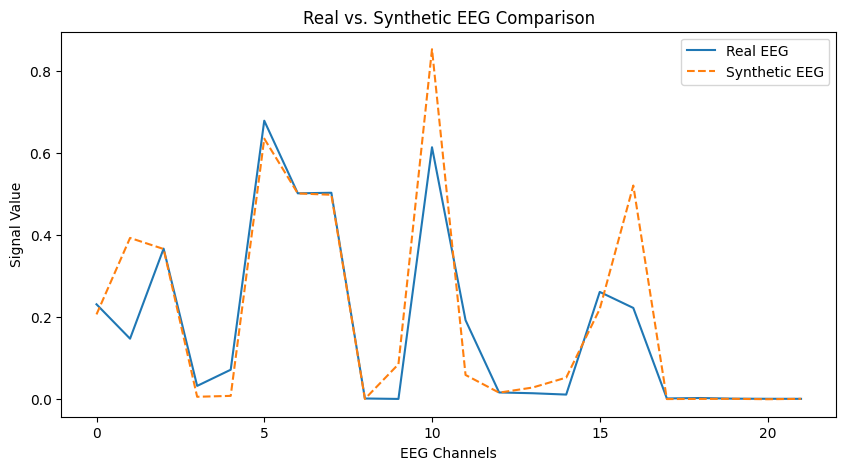

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# # Load real and synthetic EEG data
# real_data = pd.read_csv("Normalized_Features.csv")
# synthetic_data = pd.read_csv("Syn_data.csv")

# # Select a random real and synthetic sample
# real_sample = real_data.iloc[0, 1:-1].values  # First real EEG sample
# synthetic_sample = synthetic_data.iloc[0, 1:-1].values  # First synthetic EEG sample

# # Plot EEG signals for comparison
# plt.figure(figsize=(10, 5))
# plt.plot(real_sample, label="Real EEG", linestyle="-")
# plt.plot(synthetic_sample, label="Synthetic EEG", linestyle="--")
# plt.xlabel("EEG Channels")
# plt.ylabel("Signal Value")
# plt.title("Real vs. Synthetic EEG Comparison")
# plt.legend()
# plt.show()


In [ ]:
# import pandas as pd

# # Load the CSV files
# features_df = pd.read_csv("Normalized_Features.csv")
# synthetic_df = pd.read_csv("Syn_data.csv")

# # Combine both files (append rows)
# combined_df = pd.concat([features_df, synthetic_df], ignore_index=True)

# # Shuffle the combined dataset
# combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# # Save to a new CSV file
# combined_csv_output_filename = "Combined_data.csv"
# combined_df.to_csv(combined_csv_output_filename, index=False)

# print(f"Shuffled combined EEG data saved to {combined_csv_output_filename}")


Shuffled combined EEG data saved to Combined_data.csv


## DL with Syn Data

### CNN

#### 70 30

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4230, 22, 1)
Testing Data Shape: (1814, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5493 - loss: 1.0027 - val_accuracy: 0.5612 - val_loss: 0.9673 - learning_rate: 0.0010
Epoch 2/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5692 - loss: 0.9604 - val_accuracy: 0.5766 - val_loss: 0.9481 - learning_rate: 0.0010
Epoch 3/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5853 - loss: 0.9358 - val_accuracy: 0.5777 - val_loss: 0.9477 - learning_rate: 0.0010
Epoch 4/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5984 - loss: 0.9172 - val_accuracy: 0.5904 - val_loss: 0.9553 - learning_rate: 0.0010
Epoch 5/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5847 - loss: 0.9313 - val_accuracy: 0.5788 - val_loss: 0.9329 - learning_rate: 0.0010
Epoch 6/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5945 - loss: 0.9134 - val_accuracy: 0.5965 - val_loss: 0.9317 - learning_rate: 0.0010
Epoch 7/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6048 - loss: 0.8874 - val_a

Model saved successfully.
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6210 - loss: 0.8959
Test Accuracy: 62.29%
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


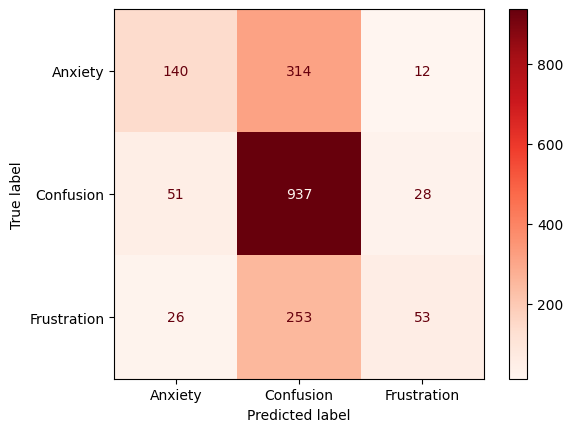


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.65      0.30      0.41       466
   Confusion       0.62      0.92      0.74      1016
 Frustration       0.57      0.16      0.25       332

    accuracy                           0.62      1814
   macro avg       0.61      0.46      0.47      1814
weighted avg       0.62      0.62      0.57      1814



In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # Load EEG CSV data
# file_path = 'Combined_data.csv'  # Update with actual CSV file name
# data = pd.read_csv(file_path)

# # Print dataset shape and columns for debugging
# print("Dataset Shape:", data.shape)
# print("Columns:", data.columns)

# # Drop the first column (non-numeric identifier)
# data_numeric = data.iloc[:, 1:-1]  # Exclude first (ID) and last (label) columns

# # Extract EEG features (middle columns)
# X = data_numeric.values  # Only EEG feature columns
# y = data.iloc[:, -1].values  # Labels from last column

# # Encode labels (Anxiety, Confusion, Frustration)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Normalize EEG features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y_encoded, test_size=0.3, random_state=42
# )

# # Reshape for CNN input (samples, time steps, features)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# print("Training Data Shape:", X_train.shape)
# print("Testing Data Shape:", X_test.shape)

# # Define CNN model
# model = keras.Sequential([
#     layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
#     layers.MaxPooling1D(pool_size=2),
#     layers.Conv1D(128, kernel_size=3, activation='relu'),
#     layers.MaxPooling1D(pool_size=2),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(3, activation='softmax')  # 3-class classification
# ])

# # Compile model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Define callbacks for better training
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# # Train model with optimized epochs and batch size
# model.fit(X_train, y_train, 
#           epochs=200, batch_size=32, 
#           validation_data=(X_test, y_test), 
#           callbacks=[early_stopping, reduce_lr])

# # Save model
# model.save('CNN_EEG_Model.h5')
# print("Model saved successfully.")

# # Evaluate model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy * 100:.2f}%')

# # Generate predictions
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_classes)

# # Display confusion matrix
# ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
# plt.savefig('CNN.png')
# plt.show()

# # Compute classification report
# report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

# # Print classification report
# print("\nClassification Report:")
# print(report)


#### 75 25

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4533, 22, 1)
Testing Data Shape: (1511, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5536 - loss: 0.9899 - val_accuracy: 0.5566 - val_loss: 0.9768 - learning_rate: 0.0010
Epoch 2/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5776 - loss: 0.9511 - val_accuracy: 0.5698 - val_loss: 0.9525 - learning_rate: 0.0010
Epoch 3/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5812 - loss: 0.9336 - val_accuracy: 0.5784 - val_loss: 0.9486 - learning_rate: 0.0010
Epoch 4/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5861 - loss: 0.9208 - val_accuracy: 0.5804 - val_loss: 0.9353 - learning_rate: 0.0010
Epoch 5/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5938 - loss: 0.9037 - val_accuracy: 0.5890 - val_loss: 0.9319 - learning_rate: 0.0010
Epoch 6/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6098 - loss: 0.8898 - val_accuracy: 0.5890 - val_loss: 0.9339 - learning_rate: 0.0010
Epoch 7/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6081 - loss: 0.8803 - val_a

Model saved successfully.
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6194 - loss: 0.9133
Test Accuracy: 61.81%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


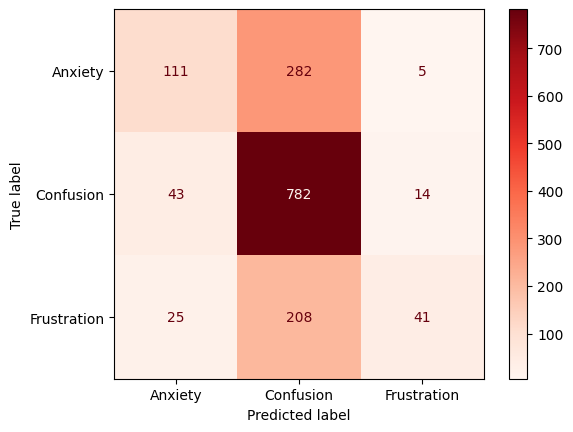


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.62      0.28      0.38       398
   Confusion       0.61      0.93      0.74       839
 Frustration       0.68      0.15      0.25       274

    accuracy                           0.62      1511
   macro avg       0.64      0.45      0.46      1511
weighted avg       0.63      0.62      0.56      1511



In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # Load EEG CSV data
# file_path = 'Combined_data.csv'  # Update with actual CSV file name
# data = pd.read_csv(file_path)

# # Print dataset shape and columns for debugging
# print("Dataset Shape:", data.shape)
# print("Columns:", data.columns)

# # Drop the first column (non-numeric identifier)
# data_numeric = data.iloc[:, 1:-1]  # Exclude first (ID) and last (label) columns

# # Extract EEG features (middle columns)
# X = data_numeric.values  # Only EEG feature columns
# y = data.iloc[:, -1].values  # Labels from last column

# # Encode labels (Anxiety, Confusion, Frustration)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Normalize EEG features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y_encoded, test_size=0.25, random_state=42
# )

# # Reshape for CNN input (samples, time steps, features)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# print("Training Data Shape:", X_train.shape)
# print("Testing Data Shape:", X_test.shape)

# # Define CNN model
# model = keras.Sequential([
#     layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
#     layers.MaxPooling1D(pool_size=2),
#     layers.Conv1D(128, kernel_size=3, activation='relu'),
#     layers.MaxPooling1D(pool_size=2),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(3, activation='softmax')  # 3-class classification
# ])

# # Compile model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Define callbacks for better training
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# # Train model with optimized epochs and batch size
# model.fit(X_train, y_train, 
#           epochs=200, batch_size=32, 
#           validation_data=(X_test, y_test), 
#           callbacks=[early_stopping, reduce_lr])

# # Save model
# model.save('CNN_EEG_Model.h5')
# print("Model saved successfully.")

# # Evaluate model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy * 100:.2f}%')

# # Generate predictions
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_classes)

# # Display confusion matrix
# ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
# plt.savefig('CNN.png')
# plt.show()

# # Compute classification report
# report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

# # Print classification report
# print("\nClassification Report:")
# print(report)


#### 80 20

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4835, 22, 1)
Testing Data Shape: (1209, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5572 - loss: 0.9918 - val_accuracy: 0.5451 - val_loss: 1.0229 - learning_rate: 0.0010
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5754 - loss: 0.9439 - val_accuracy: 0.5666 - val_loss: 0.9550 - learning_rate: 0.0010
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5663 - loss: 0.9401 - val_accuracy: 0.5649 - val_loss: 0.9477 - learning_rate: 0.0010
Epoch 4/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5918 - loss: 0.9194 - val_accuracy: 0.5782 - val_loss: 0.9349 - learning_rate: 0.0010
Epoch 5/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6050 - loss: 0.9103 - val_accuracy: 0.5831 - val_loss: 0.9411 - learning_rate: 0.0010
Epoch 6/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5981 - loss: 0.9119 - val_accuracy: 0.5955 - val_loss: 0.9214 - learning_rate: 0.0010
Epoch 7/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6152 - loss: 0.8844 - val_a

Model saved successfully.
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6248 - loss: 0.9055 
Test Accuracy: 62.12%
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


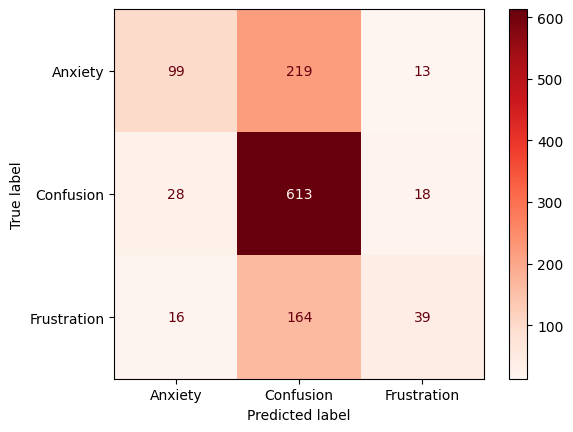


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.69      0.30      0.42       331
   Confusion       0.62      0.93      0.74       659
 Frustration       0.56      0.18      0.27       219

    accuracy                           0.62      1209
   macro avg       0.62      0.47      0.48      1209
weighted avg       0.63      0.62      0.57      1209



In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # Load EEG CSV data
# file_path = 'Combined_data.csv'  # Update with actual CSV file name
# data = pd.read_csv(file_path)

# # Print dataset shape and columns for debugging
# print("Dataset Shape:", data.shape)
# print("Columns:", data.columns)

# # Drop the first column (non-numeric identifier)
# data_numeric = data.iloc[:, 1:-1]  # Exclude first (ID) and last (label) columns

# # Extract EEG features (middle columns)
# X = data_numeric.values  # Only EEG feature columns
# y = data.iloc[:, -1].values  # Labels from last column

# # Encode labels (Anxiety, Confusion, Frustration)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Normalize EEG features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y_encoded, test_size=0.2, random_state=42
# )

# # Reshape for CNN input (samples, time steps, features)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# print("Training Data Shape:", X_train.shape)
# print("Testing Data Shape:", X_test.shape)

# # Define CNN model
# model = keras.Sequential([
#     layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
#     layers.MaxPooling1D(pool_size=2),
#     layers.Conv1D(128, kernel_size=3, activation='relu'),
#     layers.MaxPooling1D(pool_size=2),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(3, activation='softmax')  # 3-class classification
# ])

# # Compile model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Define callbacks for better training
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# # Train model with optimized epochs and batch size
# model.fit(X_train, y_train, 
#           epochs=200, batch_size=32, 
#           validation_data=(X_test, y_test), 
#           callbacks=[early_stopping, reduce_lr])

# # Save model
# model.save('CNN_EEG_Model.h5')
# print("Model saved successfully.")

# # Evaluate model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy * 100:.2f}%')

# # Generate predictions
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_classes)

# # Display confusion matrix
# ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
# plt.savefig('CNN.png')
# plt.show()

# # Compute classification report
# report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

# # Print classification report
# print("\nClassification Report:")
# print(report)


#### 90 10

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (5439, 22, 1)
Testing Data Shape: (605, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5451 - loss: 0.9918 - val_accuracy: 0.5669 - val_loss: 0.9504 - learning_rate: 0.0010
Epoch 2/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5665 - loss: 0.9616 - val_accuracy: 0.5785 - val_loss: 0.9352 - learning_rate: 0.0010
Epoch 3/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5862 - loss: 0.9360 - val_accuracy: 0.5917 - val_loss: 0.9166 - learning_rate: 0.0010
Epoch 4/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5831 - loss: 0.9286 - val_accuracy: 0.5917 - val_loss: 0.9168 - learning_rate: 0.0010
Epoch 5/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5867 - loss: 0.9214 - val_accuracy: 0.5950 - val_loss: 0.9084 - learning_rate: 0.0010
Epoch 6/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6148 - loss: 0.8817 - val_accuracy: 0.6198 - val_loss: 0.8965 - learning_rate: 0.0010
Epoch 7/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6336 - loss: 0.8671 - val_a

Model saved successfully.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6098 - loss: 0.8869 
Test Accuracy: 62.81%
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


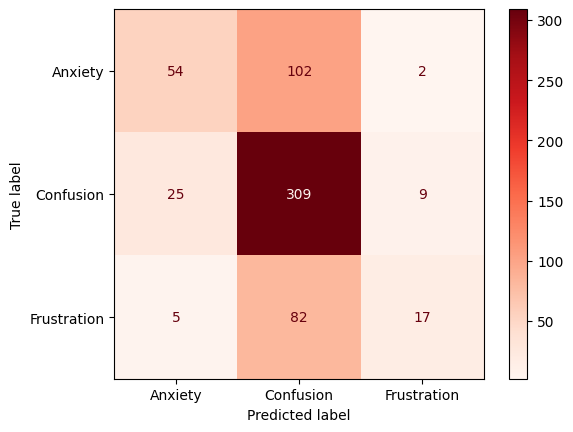


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.64      0.34      0.45       158
   Confusion       0.63      0.90      0.74       343
 Frustration       0.61      0.16      0.26       104

    accuracy                           0.63       605
   macro avg       0.63      0.47      0.48       605
weighted avg       0.63      0.63      0.58       605



In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # Load EEG CSV data
# file_path = 'Combined_data.csv'  # Update with actual CSV file name
# data = pd.read_csv(file_path)

# # Print dataset shape and columns for debugging
# print("Dataset Shape:", data.shape)
# print("Columns:", data.columns)

# # Drop the first column (non-numeric identifier)
# data_numeric = data.iloc[:, 1:-1]  # Exclude first (ID) and last (label) columns

# # Extract EEG features (middle columns)
# X = data_numeric.values  # Only EEG feature columns
# y = data.iloc[:, -1].values  # Labels from last column

# # Encode labels (Anxiety, Confusion, Frustration)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Normalize EEG features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X_scaled, y_encoded, test_size=0.1, random_state=42
# )

# # Reshape for CNN input (samples, time steps, features)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# print("Training Data Shape:", X_train.shape)
# print("Testing Data Shape:", X_test.shape)

# # Define CNN model
# model = keras.Sequential([
#     layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
#     layers.MaxPooling1D(pool_size=2),
#     layers.Conv1D(128, kernel_size=3, activation='relu'),
#     layers.MaxPooling1D(pool_size=2),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(3, activation='softmax')  # 3-class classification
# ])

# # Compile model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Define callbacks for better training
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# # Train model with optimized epochs and batch size
# model.fit(X_train, y_train, 
#           epochs=200, batch_size=32, 
#           validation_data=(X_test, y_test), 
#           callbacks=[early_stopping, reduce_lr])

# # Save model
# model.save('CNN_EEG_Model.h5')
# print("Model saved successfully.")

# # Evaluate model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy * 100:.2f}%')

# # Generate predictions
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_classes)

# # Display confusion matrix
# ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
# plt.savefig('CNN.png')
# plt.show()

# # Compute classification report
# report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

# # Print classification report
# print("\nClassification Report:")
# print(report)


### LSTM

#### 70 30 

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4230, 22, 1)
Testing Data Shape: (1814, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5432 - loss: 1.0420 - val_accuracy: 0.5601 - val_loss: 0.9867 - learning_rate: 5.0000e-04
Epoch 2/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5644 - loss: 0.9895 - val_accuracy: 0.5601 - val_loss: 0.9857 - learning_rate: 5.0000e-04
Epoch 3/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5587 - loss: 0.9926 - val_accuracy: 0.5601 - val_loss: 0.9812 - learning_rate: 5.0000e-04
Epoch 4/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5602 - loss: 0.9910 - val_accuracy: 0.5606 - val_loss: 0.9833 - learning_rate: 5.0000e-04
Epoch 5/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5584 - loss: 0.9764 - val_accuracy: 0.5606 - val_loss: 0.9797 - learning_rate: 5.0000e-04
Epoch 6/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5640 - loss: 0.9771 - val_accuracy: 0.5601 - val_loss: 0.9773 - learning_rate: 5.0000e-04
Epoch 7/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy

LSTM model saved successfully.
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5678 - loss: 0.9663
Test Accuracy: 56.84%
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


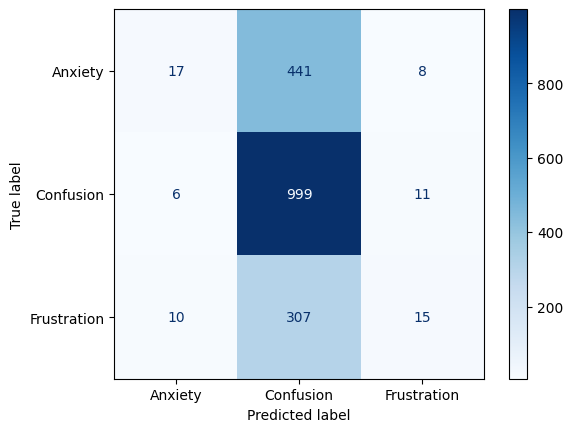


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.52      0.04      0.07       466
   Confusion       0.57      0.98      0.72      1016
 Frustration       0.44      0.05      0.08       332

    accuracy                           0.57      1814
   macro avg       0.51      0.35      0.29      1814
weighted avg       0.53      0.57      0.44      1814



In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # Load EEG CSV data
# file_path = 'Combined_data.csv'  # Ensure this is the correct file
# data = pd.read_csv(file_path)

# # Print dataset shape and columns for debugging
# print("Dataset Shape:", data.shape)
# print("Columns:", data.columns)

# # Drop the first column (non-numeric identifier) and extract features & labels
# X = data.iloc[:, 1:-1].values  # EEG feature columns
# y = data.iloc[:, -1].values  # Labels from last column

# # Encode labels (Anxiety, Confusion, Frustration)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Normalize EEG features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# # Reshape for LSTM input (samples, time steps, features)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# print("Training Data Shape:", X_train.shape)
# print("Testing Data Shape:", X_test.shape)

# # Define LSTM model
# model = keras.Sequential([
#     layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
#     layers.LSTM(128, return_sequences=True),
#     layers.LSTM(64),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(3, activation='softmax')  # 3-class classification
# ])

# # Compile model
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# # Train model
# history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
#                     validation_data=(X_test, y_test), 
#                     callbacks=[early_stopping, reduce_lr])

# # Save model
# model.save('LSTM_EEG_Model.h5')
# print("LSTM model saved successfully.")

# # Evaluate model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy * 100:.2f}%')

# # Generate predictions
# y_pred = np.argmax(model.predict(X_test), axis=1)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Display confusion matrix
# ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
# plt.savefig('confusion_matrix_LSTM.png')
# plt.show()

# # Compute classification report
# report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# # Print classification report
# print("\nClassification Report:")
# print(report)


#### 75 25

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4533, 22, 1)
Testing Data Shape: (1511, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5296 - loss: 1.0257 - val_accuracy: 0.5553 - val_loss: 1.0019 - learning_rate: 5.0000e-04
Epoch 2/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5533 - loss: 0.9973 - val_accuracy: 0.5553 - val_loss: 0.9854 - learning_rate: 5.0000e-04
Epoch 3/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5572 - loss: 0.9904 - val_accuracy: 0.5553 - val_loss: 0.9835 - learning_rate: 5.0000e-04
Epoch 4/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5540 - loss: 0.9913 - val_accuracy: 0.5559 - val_loss: 0.9803 - learning_rate: 5.0000e-04
Epoch 5/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5600 - loss: 0.9839 - val_accuracy: 0.5553 - val_loss: 0.9808 - learning_rate: 5.0000e-04
Epoch 6/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5686 - loss: 0.9691 - val_accuracy: 0.5559 - val_loss: 0.9760 - learning_rate: 5.0000e-04
Epoch 7/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy

LSTM model saved successfully.
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5700 - loss: 0.9373
Test Accuracy: 57.38%
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


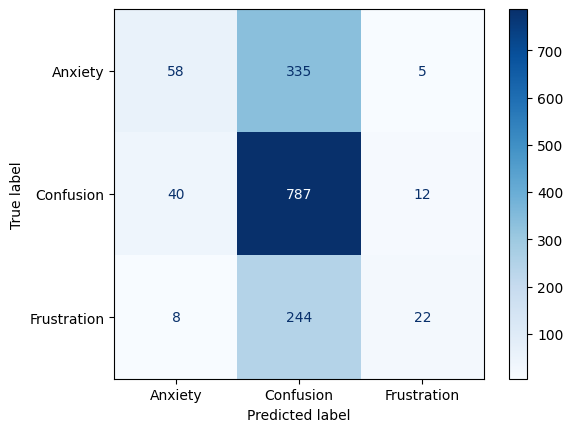


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.55      0.15      0.23       398
   Confusion       0.58      0.94      0.71       839
 Frustration       0.56      0.08      0.14       274

    accuracy                           0.57      1511
   macro avg       0.56      0.39      0.36      1511
weighted avg       0.57      0.57      0.48      1511



In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # Load EEG CSV data
# file_path = 'Combined_data.csv'  # Ensure this is the correct file
# data = pd.read_csv(file_path)

# # Print dataset shape and columns for debugging
# print("Dataset Shape:", data.shape)
# print("Columns:", data.columns)

# # Drop the first column (non-numeric identifier) and extract features & labels
# X = data.iloc[:, 1:-1].values  # EEG feature columns
# y = data.iloc[:, -1].values  # Labels from last column

# # Encode labels (Anxiety, Confusion, Frustration)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Normalize EEG features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.25, random_state=42)

# # Reshape for LSTM input (samples, time steps, features)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# print("Training Data Shape:", X_train.shape)
# print("Testing Data Shape:", X_test.shape)

# # Define LSTM model
# model = keras.Sequential([
#     layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
#     layers.LSTM(128, return_sequences=True),
#     layers.LSTM(64),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(3, activation='softmax')  # 3-class classification
# ])

# # Compile model
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# # Train model
# history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
#                     validation_data=(X_test, y_test), 
#                     callbacks=[early_stopping, reduce_lr])

# # Save model
# model.save('LSTM_EEG_Model.h5')
# print("LSTM model saved successfully.")

# # Evaluate model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy * 100:.2f}%')

# # Generate predictions
# y_pred = np.argmax(model.predict(X_test), axis=1)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Display confusion matrix
# ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
# plt.savefig('confusion_matrix_LSTM.png')
# plt.show()

# # Compute classification report
# report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# # Print classification report
# print("\nClassification Report:")
# print(report)


#### 80 20

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4835, 22, 1)
Testing Data Shape: (1209, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5551 - loss: 1.0194 - val_accuracy: 0.5451 - val_loss: 0.9943 - learning_rate: 5.0000e-04
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5536 - loss: 0.9985 - val_accuracy: 0.5451 - val_loss: 0.9938 - learning_rate: 5.0000e-04
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5511 - loss: 0.9995 - val_accuracy: 0.5451 - val_loss: 0.9961 - learning_rate: 5.0000e-04
Epoch 4/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5688 - loss: 0.9809 - val_accuracy: 0.5451 - val_loss: 0.9932 - learning_rate: 5.0000e-04
Epoch 5/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5806 - loss: 0.9661 - val_accuracy: 0.5451 - val_loss: 0.9951 - learning_rate: 5.0000e-04
Epoch 6/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5641 - loss: 0.9810 - val_accuracy: 0.5459 - val_loss: 0.9954 - learning_rate: 5.0000e-04
Epoch 7/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy

LSTM model saved successfully.
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5665 - loss: 0.9399
Test Accuracy: 57.15%
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


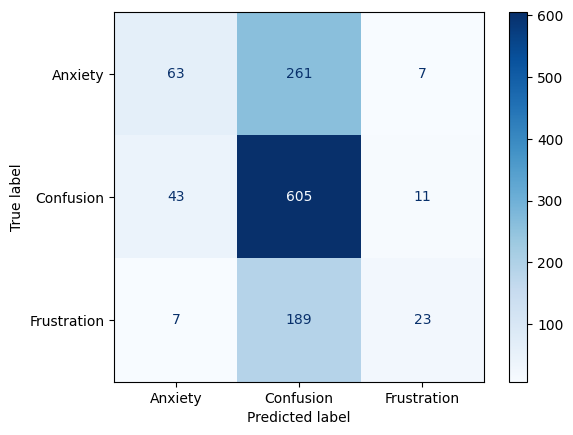


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.56      0.19      0.28       331
   Confusion       0.57      0.92      0.71       659
 Frustration       0.56      0.11      0.18       219

    accuracy                           0.57      1209
   macro avg       0.56      0.40      0.39      1209
weighted avg       0.57      0.57      0.49      1209



In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # Load EEG CSV data
# file_path = 'Combined_data.csv'  # Ensure this is the correct file
# data = pd.read_csv(file_path)

# # Print dataset shape and columns for debugging
# print("Dataset Shape:", data.shape)
# print("Columns:", data.columns)

# # Drop the first column (non-numeric identifier) and extract features & labels
# X = data.iloc[:, 1:-1].values  # EEG feature columns
# y = data.iloc[:, -1].values  # Labels from last column

# # Encode labels (Anxiety, Confusion, Frustration)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Normalize EEG features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# # Reshape for LSTM input (samples, time steps, features)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# print("Training Data Shape:", X_train.shape)
# print("Testing Data Shape:", X_test.shape)

# # Define LSTM model
# model = keras.Sequential([
#     layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
#     layers.LSTM(128, return_sequences=True),
#     layers.LSTM(64),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(3, activation='softmax')  # 3-class classification
# ])

# # Compile model
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# # Train model
# history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
#                     validation_data=(X_test, y_test), 
#                     callbacks=[early_stopping, reduce_lr])

# # Save model
# model.save('LSTM_EEG_Model.h5')
# print("LSTM model saved successfully.")

# # Evaluate model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy * 100:.2f}%')

# # Generate predictions
# y_pred = np.argmax(model.predict(X_test), axis=1)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Display confusion matrix
# ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
# plt.savefig('confusion_matrix_LSTM.png')
# plt.show()

# # Compute classification report
# report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# # Print classification report
# print("\nClassification Report:")
# print(report)


#### 90 10

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (5439, 22, 1)
Testing Data Shape: (605, 22, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5570 - loss: 1.0230 - val_accuracy: 0.5669 - val_loss: 0.9748 - learning_rate: 5.0000e-04
Epoch 2/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5678 - loss: 0.9825 - val_accuracy: 0.5669 - val_loss: 0.9768 - learning_rate: 5.0000e-04
Epoch 3/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5620 - loss: 0.9887 - val_accuracy: 0.5669 - val_loss: 0.9775 - learning_rate: 5.0000e-04
Epoch 4/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5689 - loss: 0.9794 - val_accuracy: 0.5669 - val_loss: 0.9678 - learning_rate: 5.0000e-04
Epoch 5/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5581 - loss: 0.9821 - val_accuracy: 0.5669 - val_loss: 0.9669 - learning_rate: 5.0000e-04
Epoch 6/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5674 - loss: 0.9742 - val_accuracy: 0.5669 - val_loss: 0.9656 - learning_rate: 5.0000e-04
Epoch 7/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy

LSTM model saved successfully.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5857 - loss: 0.9187
Test Accuracy: 59.34%
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


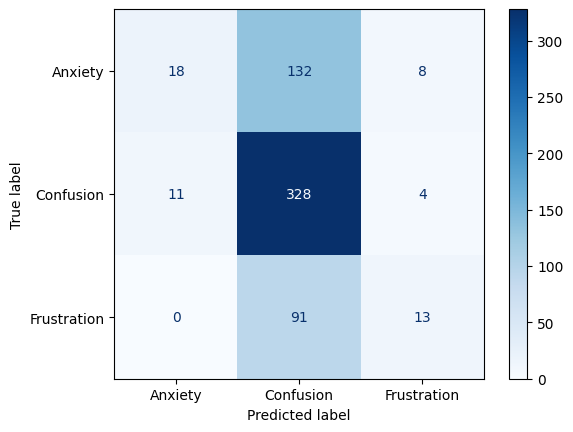


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.62      0.11      0.19       158
   Confusion       0.60      0.96      0.73       343
 Frustration       0.52      0.12      0.20       104

    accuracy                           0.59       605
   macro avg       0.58      0.40      0.38       605
weighted avg       0.59      0.59      0.50       605



In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # Load EEG CSV data
# file_path = 'Combined_data.csv'  # Ensure this is the correct file
# data = pd.read_csv(file_path)

# # Print dataset shape and columns for debugging
# print("Dataset Shape:", data.shape)
# print("Columns:", data.columns)

# # Drop the first column (non-numeric identifier) and extract features & labels
# X = data.iloc[:, 1:-1].values  # EEG feature columns
# y = data.iloc[:, -1].values  # Labels from last column

# # Encode labels (Anxiety, Confusion, Frustration)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Normalize EEG features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.1, random_state=42)

# # Reshape for LSTM input (samples, time steps, features)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# print("Training Data Shape:", X_train.shape)
# print("Testing Data Shape:", X_test.shape)

# # Define LSTM model
# model = keras.Sequential([
#     layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
#     layers.LSTM(128, return_sequences=True),
#     layers.LSTM(64),
#     layers.Dropout(0.3),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(3, activation='softmax')  # 3-class classification
# ])

# # Compile model
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# # Train model
# history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
#                     validation_data=(X_test, y_test), 
#                     callbacks=[early_stopping, reduce_lr])

# # Save model
# model.save('LSTM_EEG_Model.h5')
# print("LSTM model saved successfully.")

# # Evaluate model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy * 100:.2f}%')

# # Generate predictions
# y_pred = np.argmax(model.predict(X_test), axis=1)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # Display confusion matrix
# ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
# plt.savefig('confusion_matrix_LSTM.png')
# plt.show()

# # Compute classification report
# report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# # Print classification report
# print("\nClassification Report:")
# print(report)


### Conformer

#### 70 30

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4230, 22, 1)
Testing Data Shape: (1814, 22, 1)
Epoch 1/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5364 - loss: 1.0925 - val_accuracy: 0.5662 - val_loss: 0.9956 - learning_rate: 0.0010
Epoch 2/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5528 - loss: 0.9881 - val_accuracy: 0.5606 - val_loss: 0.9648 - learning_rate: 0.0010
Epoch 3/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.

Model saved successfully.
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6100 - loss: 0.8864
Test Accuracy: 60.09%
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


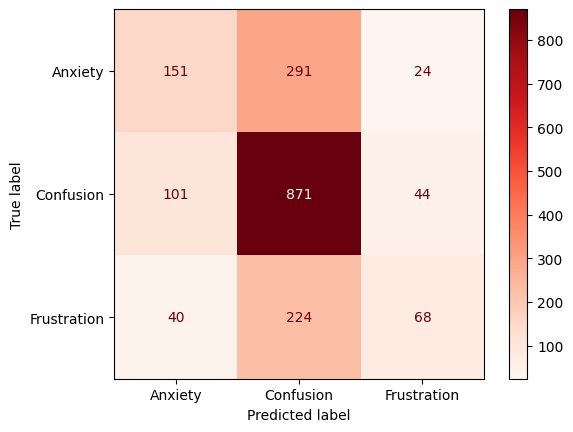


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.52      0.32      0.40       466
   Confusion       0.63      0.86      0.73      1016
 Frustration       0.50      0.20      0.29       332

    accuracy                           0.60      1814
   macro avg       0.55      0.46      0.47      1814
weighted avg       0.58      0.60      0.56      1814



In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # Load EEG CSV data
# file_path = 'Combined_data.csv'  # Ensure this is the correct file
# data = pd.read_csv(file_path)

# # Print dataset shape and columns for debugging
# print("Dataset Shape:", data.shape)
# print("Columns:", data.columns)

# # Drop the first column (non-numeric identifier) and extract features & labels
# X = data.iloc[:, 1:-1].values  # EEG feature columns
# y = data.iloc[:, -1].values  # Labels from last column

# # Encode labels (Anxiety, Confusion, Frustration)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Normalize EEG features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# # Reshape for CNN input (samples, time steps, features)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# print("Training Data Shape:", X_train.shape)
# print("Testing Data Shape:", X_test.shape)

# # Define Conformer model (CNN + Transformer)
# class ConformerModel(tf.keras.Model):
#     def __init__(self, num_classes):
#         super(ConformerModel, self).__init__()
        
#         # CNN layers for feature extraction
#         self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
#         self.maxpool1 = layers.MaxPooling1D(pool_size=2)
#         self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
#         self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        
#         # Transformer layers
#         self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
#         self.layernorm1 = layers.LayerNormalization()
#         self.feedforward = layers.Dense(128, activation='relu')
#         self.layernorm2 = layers.LayerNormalization()
        
#         # Fully connected layers for classification
#         self.flatten = layers.Flatten()
#         self.dense1 = layers.Dense(64, activation='relu')
#         self.dense2 = layers.Dense(num_classes, activation='softmax')

#     def call(self, inputs):
#         # Apply CNN layers
#         x = self.conv1(inputs)
#         x = self.maxpool1(x)
#         x = self.conv2(x)
#         x = self.maxpool2(x)
        
#         # Apply Transformer layers
#         attn_output = self.attention(x, x)
#         x = self.layernorm1(attn_output + x)  # Residual connection
#         x = self.feedforward(x)
#         x = self.layernorm2(x)
        
#         # Fully connected layers for classification
#         x = self.flatten(x)
#         x = self.dense1(x)
#         x = self.dense2(x)
        
#         return x

# # Initialize the model
# model = ConformerModel(num_classes=3)  # 3 classes: Anxiety, Confusion, Frustration

# # Compile model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Define callbacks for better training
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# # Train model with optimized epochs and batch size
# model.fit(X_train, y_train, 
#           epochs=200, batch_size=32, 
#           validation_data=(X_test, y_test), 
#           callbacks=[early_stopping, reduce_lr])

# # Save model
# model.save('Conformer_EEG_Model.h5')
# print("Model saved successfully.")

# # Evaluate model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy * 100:.2f}%')

# # Generate predictions
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_classes)

# # Display confusion matrix
# ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
# plt.savefig('confusion_matrix_Conformer.png')
# plt.show()

# # Compute classification report
# report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

# # Print classification report
# print("\nClassification Report:")
# print(report)


#### 75 25

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4533, 22, 1)
Testing Data Shape: (1511, 22, 1)
Epoch 1/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.5140 - loss: 1.0947 - val_accuracy: 0.5433 - val_loss: 1.0093 - learning_rate: 0.0010
Epoch 2/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5456 - loss: 0.9922 - val_accuracy: 0.5566 - val_loss: 1.0047 - learning_rate: 0.0010
Epoch 3/200
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.

Model saved successfully.
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6100 - loss: 0.8873
Test Accuracy: 60.75%
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


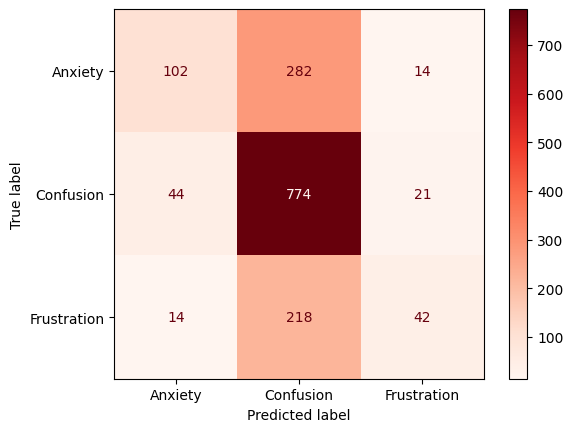


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.64      0.26      0.37       398
   Confusion       0.61      0.92      0.73       839
 Frustration       0.55      0.15      0.24       274

    accuracy                           0.61      1511
   macro avg       0.60      0.44      0.45      1511
weighted avg       0.60      0.61      0.55      1511



In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # Load EEG CSV data
# file_path = 'Combined_data.csv'  # Ensure this is the correct file
# data = pd.read_csv(file_path)

# # Print dataset shape and columns for debugging
# print("Dataset Shape:", data.shape)
# print("Columns:", data.columns)

# # Drop the first column (non-numeric identifier) and extract features & labels
# X = data.iloc[:, 1:-1].values  # EEG feature columns
# y = data.iloc[:, -1].values  # Labels from last column

# # Encode labels (Anxiety, Confusion, Frustration)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Normalize EEG features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.25, random_state=42)

# # Reshape for CNN input (samples, time steps, features)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# print("Training Data Shape:", X_train.shape)
# print("Testing Data Shape:", X_test.shape)

# # Define Conformer model (CNN + Transformer)
# class ConformerModel(tf.keras.Model):
#     def __init__(self, num_classes):
#         super(ConformerModel, self).__init__()
        
#         # CNN layers for feature extraction
#         self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
#         self.maxpool1 = layers.MaxPooling1D(pool_size=2)
#         self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
#         self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        
#         # Transformer layers
#         self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
#         self.layernorm1 = layers.LayerNormalization()
#         self.feedforward = layers.Dense(128, activation='relu')
#         self.layernorm2 = layers.LayerNormalization()
        
#         # Fully connected layers for classification
#         self.flatten = layers.Flatten()
#         self.dense1 = layers.Dense(64, activation='relu')
#         self.dense2 = layers.Dense(num_classes, activation='softmax')

#     def call(self, inputs):
#         # Apply CNN layers
#         x = self.conv1(inputs)
#         x = self.maxpool1(x)
#         x = self.conv2(x)
#         x = self.maxpool2(x)
        
#         # Apply Transformer layers
#         attn_output = self.attention(x, x)
#         x = self.layernorm1(attn_output + x)  # Residual connection
#         x = self.feedforward(x)
#         x = self.layernorm2(x)
        
#         # Fully connected layers for classification
#         x = self.flatten(x)
#         x = self.dense1(x)
#         x = self.dense2(x)
        
#         return x

# # Initialize the model
# model = ConformerModel(num_classes=3)  # 3 classes: Anxiety, Confusion, Frustration

# # Compile model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Define callbacks for better training
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# # Train model with optimized epochs and batch size
# model.fit(X_train, y_train, 
#           epochs=200, batch_size=32, 
#           validation_data=(X_test, y_test), 
#           callbacks=[early_stopping, reduce_lr])

# # Save model
# model.save('Conformer_EEG_Model.h5')
# print("Model saved successfully.")

# # Evaluate model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy * 100:.2f}%')

# # Generate predictions
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_classes)

# # Display confusion matrix
# ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
# plt.savefig('confusion_matrix_Conformer.png')
# plt.show()

# # Compute classification report
# report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

# # Print classification report
# print("\nClassification Report:")
# print(report)


#### 80 20

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (4835, 22, 1)
Testing Data Shape: (1209, 22, 1)
Epoch 1/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5436 - loss: 1.0719 - val_accuracy: 0.5451 - val_loss: 0.9903 - learning_rate: 0.0010
Epoch 2/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5700 - loss: 0.9677 - val_accuracy: 0.5567 - val_loss: 0.9666 - learning_rate: 0.0010
Epoch 3/200
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5

Model saved successfully.
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6082 - loss: 0.8901
Test Accuracy: 61.04%
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


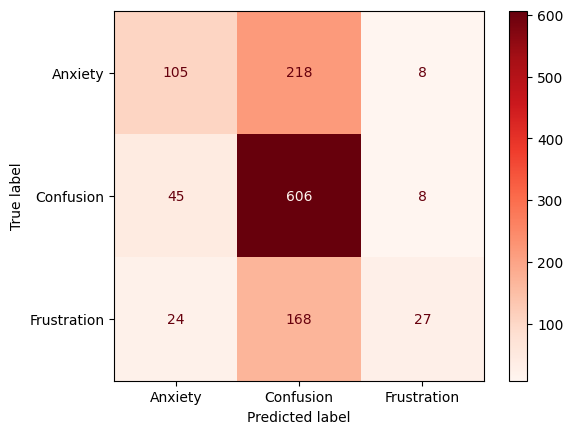


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.60      0.32      0.42       331
   Confusion       0.61      0.92      0.73       659
 Frustration       0.63      0.12      0.21       219

    accuracy                           0.61      1209
   macro avg       0.61      0.45      0.45      1209
weighted avg       0.61      0.61      0.55      1209



In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # Load EEG CSV data
# file_path = 'Combined_data.csv'  # Ensure this is the correct file
# data = pd.read_csv(file_path)

# # Print dataset shape and columns for debugging
# print("Dataset Shape:", data.shape)
# print("Columns:", data.columns)

# # Drop the first column (non-numeric identifier) and extract features & labels
# X = data.iloc[:, 1:-1].values  # EEG feature columns
# y = data.iloc[:, -1].values  # Labels from last column

# # Encode labels (Anxiety, Confusion, Frustration)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Normalize EEG features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# # Reshape for CNN input (samples, time steps, features)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# print("Training Data Shape:", X_train.shape)
# print("Testing Data Shape:", X_test.shape)

# # Define Conformer model (CNN + Transformer)
# class ConformerModel(tf.keras.Model):
#     def __init__(self, num_classes):
#         super(ConformerModel, self).__init__()
        
#         # CNN layers for feature extraction
#         self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
#         self.maxpool1 = layers.MaxPooling1D(pool_size=2)
#         self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
#         self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        
#         # Transformer layers
#         self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
#         self.layernorm1 = layers.LayerNormalization()
#         self.feedforward = layers.Dense(128, activation='relu')
#         self.layernorm2 = layers.LayerNormalization()
        
#         # Fully connected layers for classification
#         self.flatten = layers.Flatten()
#         self.dense1 = layers.Dense(64, activation='relu')
#         self.dense2 = layers.Dense(num_classes, activation='softmax')

#     def call(self, inputs):
#         # Apply CNN layers
#         x = self.conv1(inputs)
#         x = self.maxpool1(x)
#         x = self.conv2(x)
#         x = self.maxpool2(x)
        
#         # Apply Transformer layers
#         attn_output = self.attention(x, x)
#         x = self.layernorm1(attn_output + x)  # Residual connection
#         x = self.feedforward(x)
#         x = self.layernorm2(x)
        
#         # Fully connected layers for classification
#         x = self.flatten(x)
#         x = self.dense1(x)
#         x = self.dense2(x)
        
#         return x

# # Initialize the model
# model = ConformerModel(num_classes=3)  # 3 classes: Anxiety, Confusion, Frustration

# # Compile model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Define callbacks for better training
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# # Train model with optimized epochs and batch size
# model.fit(X_train, y_train, 
#           epochs=200, batch_size=32, 
#           validation_data=(X_test, y_test), 
#           callbacks=[early_stopping, reduce_lr])

# # Save model
# model.save('Conformer_EEG_Model.h5')
# print("Model saved successfully.")

# # Evaluate model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy * 100:.2f}%')

# # Generate predictions
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_classes)

# # Display confusion matrix
# ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
# plt.savefig('confusion_matrix_Conformer.png')
# plt.show()

# # Compute classification report
# report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

# # Print classification report
# print("\nClassification Report:")
# print(report)


#### 90 10

Dataset Shape: (6044, 24)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power', 'Ch0_Max_Power_Freq',
       'Ch0_RBP_Delta', 'Ch0_RBP_Theta', 'Ch0_RBP_Alpha', 'Ch0_RBP_Beta',
       'Ch0_RBP_Gamma', 'Ch0_Higuchi_FD', 'Ch0_Petrosian_FD',
       'Ch0_Wavelet_Energy_0', 'Ch0_Wavelet_Energy_1', 'Ch0_Wavelet_Energy_2',
       'Ch0_Wavelet_Energy_3', 'Ch0_Wavelet_Energy_4', 'Label'],
      dtype='object')
Training Data Shape: (5439, 22, 1)
Testing Data Shape: (605, 22, 1)
Epoch 1/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5363 - loss: 1.0705 - val_accuracy: 0.5669 - val_loss: 0.9681 - learning_rate: 0.0010
Epoch 2/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5563 - loss: 0.9780 - val_accuracy: 0.5736 - val_loss: 0.9476 - learning_rate: 0.0010
Epoch 3/200
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.563

Model saved successfully.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6106 - loss: 0.9008 
Test Accuracy: 63.97%
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


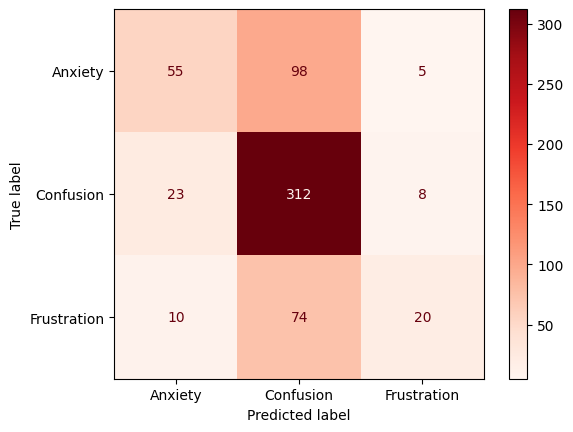


Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.62      0.35      0.45       158
   Confusion       0.64      0.91      0.75       343
 Frustration       0.61      0.19      0.29       104

    accuracy                           0.64       605
   macro avg       0.63      0.48      0.50       605
weighted avg       0.63      0.64      0.59       605



In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# # Load EEG CSV data
# file_path = 'Combined_data.csv'  # Ensure this is the correct file
# data = pd.read_csv(file_path)

# # Print dataset shape and columns for debugging
# print("Dataset Shape:", data.shape)
# print("Columns:", data.columns)

# # Drop the first column (non-numeric identifier) and extract features & labels
# X = data.iloc[:, 1:-1].values  # EEG feature columns
# y = data.iloc[:, -1].values  # Labels from last column

# # Encode labels (Anxiety, Confusion, Frustration)
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

# # Normalize EEG features
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.1, random_state=42)

# # Reshape for CNN input (samples, time steps, features)
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# print("Training Data Shape:", X_train.shape)
# print("Testing Data Shape:", X_test.shape)

# # Define Conformer model (CNN + Transformer)
# class ConformerModel(tf.keras.Model):
#     def __init__(self, num_classes):
#         super(ConformerModel, self).__init__()
        
#         # CNN layers for feature extraction
#         self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
#         self.maxpool1 = layers.MaxPooling1D(pool_size=2)
#         self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
#         self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        
#         # Transformer layers
#         self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
#         self.layernorm1 = layers.LayerNormalization()
#         self.feedforward = layers.Dense(128, activation='relu')
#         self.layernorm2 = layers.LayerNormalization()
        
#         # Fully connected layers for classification
#         self.flatten = layers.Flatten()
#         self.dense1 = layers.Dense(64, activation='relu')
#         self.dense2 = layers.Dense(num_classes, activation='softmax')

#     def call(self, inputs):
#         # Apply CNN layers
#         x = self.conv1(inputs)
#         x = self.maxpool1(x)
#         x = self.conv2(x)
#         x = self.maxpool2(x)
        
#         # Apply Transformer layers
#         attn_output = self.attention(x, x)
#         x = self.layernorm1(attn_output + x)  # Residual connection
#         x = self.feedforward(x)
#         x = self.layernorm2(x)
        
#         # Fully connected layers for classification
#         x = self.flatten(x)
#         x = self.dense1(x)
#         x = self.dense2(x)
        
#         return x

# # Initialize the model
# model = ConformerModel(num_classes=3)  # 3 classes: Anxiety, Confusion, Frustration

# # Compile model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Define callbacks for better training
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

# # Train model with optimized epochs and batch size
# model.fit(X_train, y_train, 
#           epochs=200, batch_size=32, 
#           validation_data=(X_test, y_test), 
#           callbacks=[early_stopping, reduce_lr])

# # Save model
# model.save('Conformer_EEG_Model.h5')
# print("Model saved successfully.")

# # Evaluate model
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f'Test Accuracy: {accuracy * 100:.2f}%')

# # Generate predictions
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_classes)

# # Display confusion matrix
# ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
# plt.savefig('confusion_matrix_Conformer.png')
# plt.show()

# # Compute classification report
# report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

# # Print classification report
# print("\nClassification Report:")
# print(report)


## DL without Syn data

### CNN

#### 70 30

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2130, 418, 1)
Testing Data Shape: (914, 418, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5690 - loss: 0.9241 - val_accuracy: 0.7309 - val_loss: 0.6086 - learning_rate: 0.0010
Epoch 2/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7613 - loss: 0.5336 - val_accuracy: 0.7396 - val_loss: 0.5727 - learning_rate: 0.0010
Epoch 3/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8257 - loss: 0.4053 - val_accuracy: 0.7735 - val_loss: 0.5317 - learning_rate: 0.0010
Epoch 4/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8489 - loss: 0.3499 - val_accuracy: 0.7615 - val_loss: 0.5569 - learning_rate: 0.0010
Epoch 5/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8949 - loss: 0.2852 - val_accuracy: 0.7856 - val_loss: 0.5402 - learning_rate: 0.0010
Epoch 6/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9014 - loss: 0.2412 - val_accuracy: 0.7987 - val_loss: 0.5803 - learning_rate: 0.0010
Epoch 7/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9451 - loss: 0.1616 - val_accuracy

Model saved successfully.
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7655 - loss: 0.5378
Test Accuracy: 77.35%
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


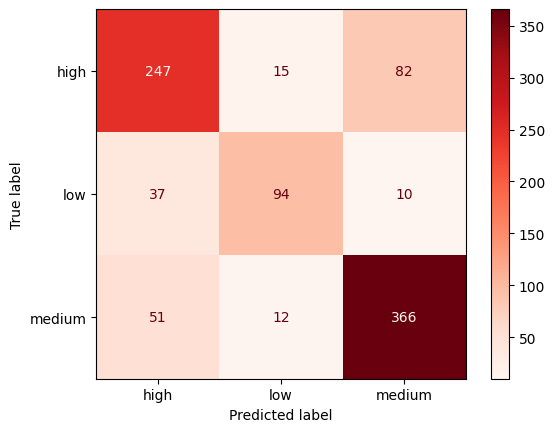


Classification Report:
              precision    recall  f1-score   support

        high       0.74      0.72      0.73       344
         low       0.78      0.67      0.72       141
      medium       0.80      0.85      0.83       429

    accuracy                           0.77       914
   macro avg       0.77      0.75      0.76       914
weighted avg       0.77      0.77      0.77       914



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Cog_Normalized_Features.csv'
data = pd.read_csv(file_path)

data_numeric = data.iloc[:, 1:-1]
X = data_numeric.values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42
)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Cog_CNN_EEG_Model.h5')

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('Cog_CNN.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(report)


#### 75 25

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2283, 418, 1)
Testing Data Shape: (761, 418, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5688 - loss: 0.9850 - val_accuracy: 0.7516 - val_loss: 0.6060 - learning_rate: 0.0010
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7797 - loss: 0.5212 - val_accuracy: 0.7674 - val_loss: 0.5508 - learning_rate: 0.0010
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8142 - loss: 0.4254 - val_accuracy: 0.7346 - val_loss: 0.5626 - learning_rate: 0.0010
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8558 - loss: 0.3408 - val_accuracy: 0.7766 - val_loss: 0.5302 - learning_rate: 0.0010
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8786 - loss: 0.2773 - val_accuracy: 0.7648 - val_loss: 0.6058 - learning_rate: 0.0010
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9087 - loss: 0.2258 - val_accuracy: 0.7530 - val_loss: 0.6298 - learning_rate: 0.0010
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9326 - loss: 0.1725 - val_accuracy

Model saved successfully.
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7936 - loss: 0.4986
Test Accuracy: 77.66%
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


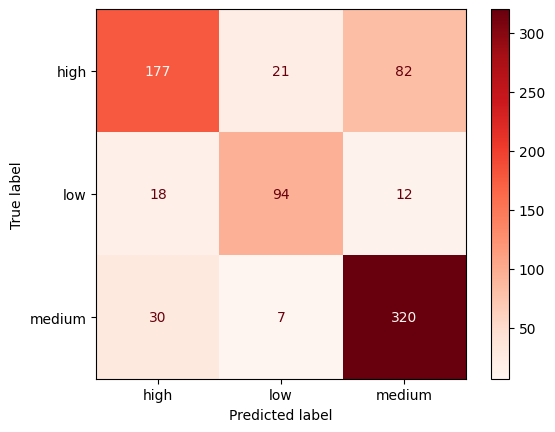


Classification Report:
              precision    recall  f1-score   support

        high       0.79      0.63      0.70       280
         low       0.77      0.76      0.76       124
      medium       0.77      0.90      0.83       357

    accuracy                           0.78       761
   macro avg       0.78      0.76      0.77       761
weighted avg       0.78      0.78      0.77       761



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Cog_Normalized_Features.csv'
data = pd.read_csv(file_path)

data_numeric = data.iloc[:, 1:-1]
X = data_numeric.values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.25, random_state=42
)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Cog_CNN_EEG_Model.h5')

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('Cog_CNN.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(report)


#### 80 20

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2435, 418, 1)
Testing Data Shape: (609, 418, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5877 - loss: 0.8447 - val_accuracy: 0.7225 - val_loss: 0.6189 - learning_rate: 0.0010
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7840 - loss: 0.5039 - val_accuracy: 0.7668 - val_loss: 0.5813 - learning_rate: 0.0010
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8250 - loss: 0.3844 - val_accuracy: 0.7537 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8583 - loss: 0.3335 - val_accuracy: 0.7767 - val_loss: 0.6040 - learning_rate: 0.0010
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8449 - loss: 0.3335 - val_accuracy: 0.7718 - val_loss: 0.5718 - learning_rate: 0.0010
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8929 - loss: 0.2572 - val_accuracy: 0.7865 - val_loss: 0.5559 - learning_rate: 0.0010
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9167 - loss: 0.2018 - val_accuracy

Model saved successfully.
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7591 - loss: 0.5030
Test Accuracy: 75.37%
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


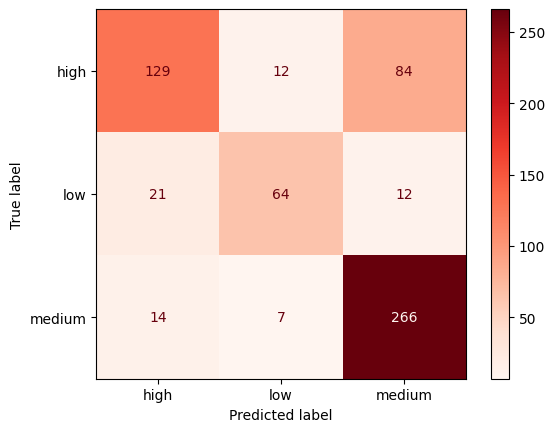


Classification Report:
              precision    recall  f1-score   support

        high       0.79      0.57      0.66       225
         low       0.77      0.66      0.71        97
      medium       0.73      0.93      0.82       287

    accuracy                           0.75       609
   macro avg       0.76      0.72      0.73       609
weighted avg       0.76      0.75      0.74       609



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Cog_Normalized_Features.csv'
data = pd.read_csv(file_path)

data_numeric = data.iloc[:, 1:-1]
X = data_numeric.values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Cog_CNN_EEG_Model.h5')

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('Cog_CNN.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(report)


#### 90 10

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2739, 418, 1)
Testing Data Shape: (305, 418, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5900 - loss: 0.8886 - val_accuracy: 0.7574 - val_loss: 0.6310 - learning_rate: 0.0010
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7692 - loss: 0.4924 - val_accuracy: 0.7508 - val_loss: 0.5828 - learning_rate: 0.0010
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8068 - loss: 0.4077 - val_accuracy: 0.8000 - val_loss: 0.5732 - learning_rate: 0.0010
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8586 - loss: 0.3247 - val_accuracy: 0.8066 - val_loss: 0.5452 - learning_rate: 0.0010
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8842 - loss: 0.2765 - val_accuracy: 0.8000 - val_loss: 0.6189 - learning_rate: 0.0010
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9115 - loss: 0.2186 - val_accuracy: 0.8033 - val_loss: 0.6962 - learning_rate: 0.0010
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9283 - loss: 0.1793 - val_accuracy

Model saved successfully.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8104 - loss: 0.4662 
Test Accuracy: 80.66%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


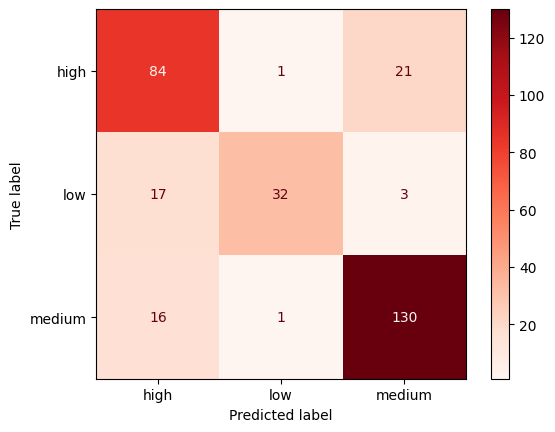


Classification Report:
              precision    recall  f1-score   support

        high       0.72      0.79      0.75       106
         low       0.94      0.62      0.74        52
      medium       0.84      0.88      0.86       147

    accuracy                           0.81       305
   macro avg       0.83      0.76      0.79       305
weighted avg       0.82      0.81      0.81       305



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Cog_Normalized_Features.csv'
data = pd.read_csv(file_path)

data_numeric = data.iloc[:, 1:-1]
X = data_numeric.values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.1, random_state=42
)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = keras.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Cog_CNN_EEG_Model.h5')

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('Cog_CNN.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("\nClassification Report:")
print(report)


### LSTM

#### 70 30 

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2130, 418, 1)
Testing Data Shape: (914, 418, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 24s 319ms/step - accuracy: 0.4379 - loss: 1.0538 - val_accuracy: 0.4814 - val_loss: 0.9806 - learning_rate: 5.0000e-04
Epoch 2/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 304ms/step - accuracy: 0.4841 - loss: 0.9802 - val_accuracy: 0.4694 - val_loss: 0.9964 - learning_rate: 5.0000e-04
Epoch 3/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 310ms/step - accuracy: 0.4982 - loss: 0.9545 - val_accuracy: 0.4716 - val_loss: 0.9654 - learning_rate: 5.0000e-04
Epoch 4/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - accuracy: 0.4843 - loss: 0.9546 - val_accuracy: 0.4869 - val_loss: 0.9474 - learning_rate: 5.0000e-04
Epoch 5/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 322ms/step - accuracy: 0.4840 - loss: 0.9468 - val_accuracy: 0.5044 - val_loss: 0.9270 - learning_rate: 5.0000e-04
Epoch 6/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 325ms/step - accuracy: 0.4970 - loss: 0.9326 - val_accuracy: 0.5569 - val_loss: 0.9131 - learning_rate: 5.0000e-04
Epoch 7/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 327ms/step - accuracy

LSTM model saved successfully.
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.6021 - loss: 0.7792
Test Accuracy: 60.18%
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step


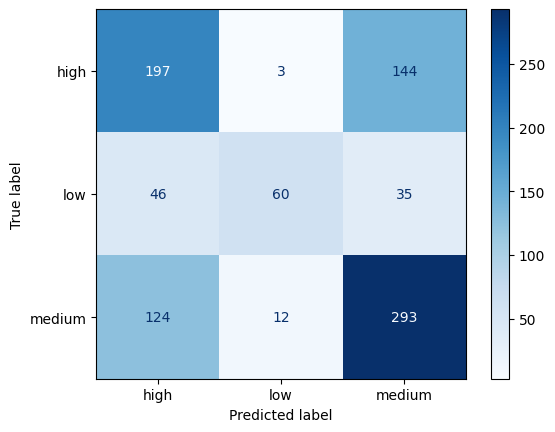


Classification Report:
              precision    recall  f1-score   support

        high       0.54      0.57      0.55       344
         low       0.80      0.43      0.56       141
      medium       0.62      0.68      0.65       429

    accuracy                           0.60       914
   macro avg       0.65      0.56      0.59       914
weighted avg       0.62      0.60      0.60       914



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Cog_Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])

model.save('Cog_LSTM_EEG_Model.h5')
print("LSTM model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = np.argmax(model.predict(X_test), axis=1)

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.savefig('Cog_confusion_matrix_LSTM.png')
plt.show()

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 75 25

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2283, 418, 1)
Testing Data Shape: (761, 418, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 24s 299ms/step - accuracy: 0.4212 - loss: 1.0510 - val_accuracy: 0.4836 - val_loss: 0.9976 - learning_rate: 5.0000e-04
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 298ms/step - accuracy: 0.4976 - loss: 0.9831 - val_accuracy: 0.4612 - val_loss: 0.9899 - learning_rate: 5.0000e-04
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 293ms/step - accuracy: 0.5011 - loss: 0.9634 - val_accuracy: 0.4888 - val_loss: 0.9671 - learning_rate: 5.0000e-04
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 297ms/step - accuracy: 0.4984 - loss: 0.9410 - val_accuracy: 0.5020 - val_loss: 0.9566 - learning_rate: 5.0000e-04
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 300ms/step - accuracy: 0.5036 - loss: 0.9255 - val_accuracy: 0.5296 - val_loss: 0.9165 - learning_rate: 5.0000e-04
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 301ms/step - accuracy: 0.5407 - loss: 0.9072 - val_accuracy: 0.5506 - val_loss: 0.8798 - learning_rate: 5.0000e-04
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 301ms/step - accuracy

LSTM model saved successfully.
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.6273 - loss: 0.7734
Test Accuracy: 61.50%
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step


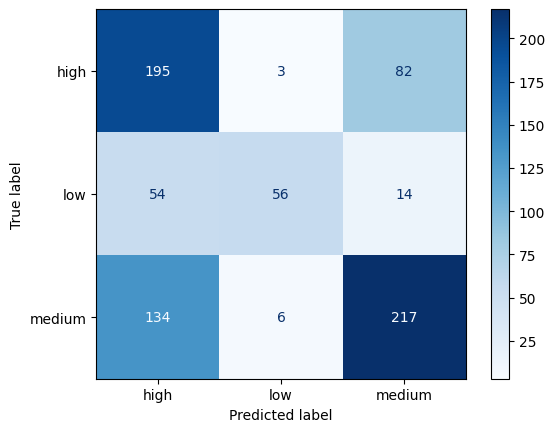


Classification Report:
              precision    recall  f1-score   support

        high       0.51      0.70      0.59       280
         low       0.86      0.45      0.59       124
      medium       0.69      0.61      0.65       357

    accuracy                           0.61       761
   macro avg       0.69      0.59      0.61       761
weighted avg       0.65      0.61      0.62       761



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Cog_Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.25, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])

model.save('Cog_LSTM_EEG_Model.h5')
print("LSTM model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = np.argmax(model.predict(X_test), axis=1)

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.savefig('Cog_confusion_matrix_LSTM.png')
plt.show()

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 80 20

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2435, 418, 1)
Testing Data Shape: (609, 418, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 305ms/step - accuracy: 0.4747 - loss: 1.0397 - val_accuracy: 0.4860 - val_loss: 1.0044 - learning_rate: 5.0000e-04
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy: 0.4689 - loss: 0.9802 - val_accuracy: 0.4910 - val_loss: 0.9836 - learning_rate: 5.0000e-04
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.4895 - loss: 0.9745 - val_accuracy: 0.5189 - val_loss: 0.9544 - learning_rate: 5.0000e-04
Epoch 4/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.5171 - loss: 0.9228 - val_accuracy: 0.5172 - val_loss: 0.9231 - learning_rate: 5.0000e-04
Epoch 5/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 292ms/step - accuracy: 0.5115 - loss: 0.8992 - val_accuracy: 0.5386 - val_loss: 0.9033 - learning_rate: 5.0000e-04
Epoch 6/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step - accuracy: 0.5327 - loss: 0.8863 - val_accuracy: 0.5550 - val_loss: 0.8829 - learning_rate: 5.0000e-04
Epoch 7/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy

LSTM model saved successfully.
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.6013 - loss: 0.8018
Test Accuracy: 60.76%
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step


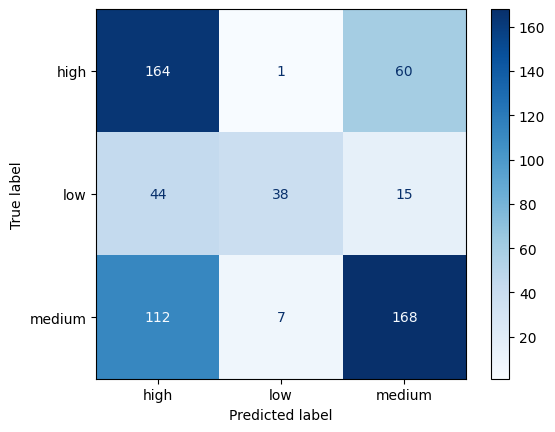


Classification Report:
              precision    recall  f1-score   support

        high       0.51      0.73      0.60       225
         low       0.83      0.39      0.53        97
      medium       0.69      0.59      0.63       287

    accuracy                           0.61       609
   macro avg       0.68      0.57      0.59       609
weighted avg       0.65      0.61      0.61       609



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Cog_Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])

model.save('Cog_LSTM_EEG_Model.h5')
print("LSTM model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = np.argmax(model.predict(X_test), axis=1)

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.savefig('Cog_confusion_matrix_LSTM.png')
plt.show()

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 90 10

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2739, 418, 1)
Testing Data Shape: (305, 418, 1)
Epoch 1/200


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 27s 285ms/step - accuracy: 0.4394 - loss: 1.0533 - val_accuracy: 0.5049 - val_loss: 0.9963 - learning_rate: 5.0000e-04
Epoch 2/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 282ms/step - accuracy: 0.4872 - loss: 0.9872 - val_accuracy: 0.4656 - val_loss: 0.9762 - learning_rate: 5.0000e-04
Epoch 3/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 281ms/step - accuracy: 0.4778 - loss: 0.9631 - val_accuracy: 0.5541 - val_loss: 0.9615 - learning_rate: 5.0000e-04
Epoch 4/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 280ms/step - accuracy: 0.4991 - loss: 0.9418 - val_accuracy: 0.5148 - val_loss: 0.9406 - learning_rate: 5.0000e-04
Epoch 5/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 276ms/step - accuracy: 0.5241 - loss: 0.9098 - val_accuracy: 0.5049 - val_loss: 0.9285 - learning_rate: 5.0000e-04
Epoch 6/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 283ms/step - accuracy: 0.5396 - loss: 0.8786 - val_accuracy: 0.5738 - val_loss: 0.8650 - learning_rate: 5.0000e-04
Epoch 7/200
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 282ms/step - accuracy

LSTM model saved successfully.
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.6194 - loss: 0.7818
Test Accuracy: 62.30%
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step


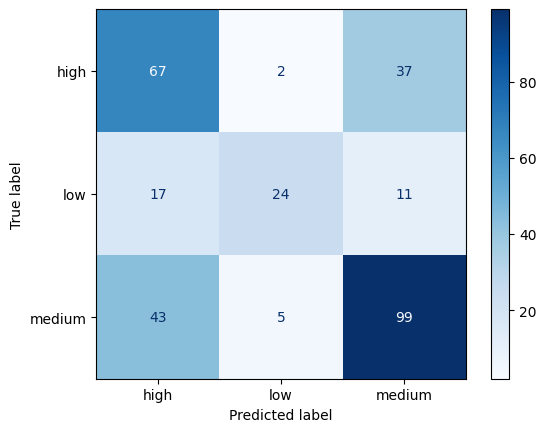


Classification Report:
              precision    recall  f1-score   support

        high       0.53      0.63      0.58       106
         low       0.77      0.46      0.58        52
      medium       0.67      0.67      0.67       147

    accuracy                           0.62       305
   macro avg       0.66      0.59      0.61       305
weighted avg       0.64      0.62      0.62       305



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Cog_Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.1, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

history = model.fit(X_train, y_train, epochs=200, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])

model.save('Cog_LSTM_EEG_Model.h5')
print("LSTM model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = np.argmax(model.predict(X_test), axis=1)

conf_matrix = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Blues')
plt.savefig('Cog_confusion_matrix_LSTM.png')
plt.show()

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


### Conformer

#### 70 30

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2130, 418, 1)
Testing Data Shape: (914, 418, 1)
Epoch 1/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.4317 - loss: 2.0364 - val_accuracy: 0.4694 - val_loss: 1.0845 - learning_rate: 0.0010
Epoch 2/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.4796 - loss: 1.0800 - val_accuracy: 0.4694 - val_loss: 1.0699 - learning_rate: 0.0010
Epoch 3/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.4721 - loss: 1.0676 - val_accuracy: 0.4694 - 

Model saved successfully.
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4710 - loss: 1.0175
Test Accuracy: 46.94%
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


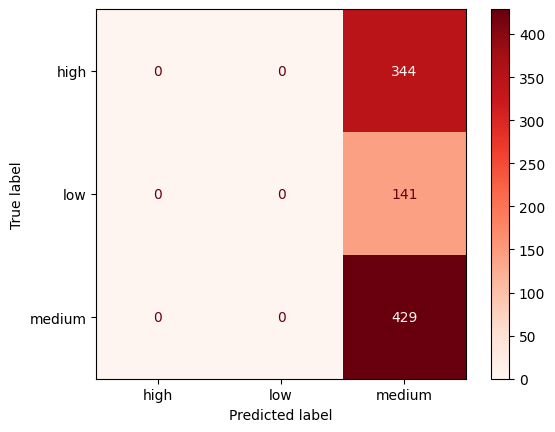


Classification Report:
              precision    recall  f1-score   support

        high       0.00      0.00      0.00       344
         low       0.00      0.00      0.00       141
      medium       0.47      1.00      0.64       429

    accuracy                           0.47       914
   macro avg       0.16      0.33      0.21       914
weighted avg       0.22      0.47      0.30       914



C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Cog_Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

class ConformerModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(ConformerModel, self).__init__()
        self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
        self.maxpool1 = layers.MaxPooling1D(pool_size=2)
        self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
        self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
        self.layernorm1 = layers.LayerNormalization()
        self.feedforward = layers.Dense(128, activation='relu')
        self.layernorm2 = layers.LayerNormalization()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        attn_output = self.attention(x, x)
        x = self.layernorm1(attn_output + x)
        x = self.feedforward(x)
        x = self.layernorm2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = ConformerModel(num_classes=3)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Cog_Conformer_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('Cog_confusion_matrix_Conformer.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 75 25

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2283, 418, 1)
Testing Data Shape: (761, 418, 1)
Epoch 1/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.4392 - loss: 2.2029 - val_accuracy: 0.5848 - val_loss: 1.0225 - learning_rate: 0.0010
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.4970 - loss: 0.9539 - val_accuracy: 0.5926 - val_loss: 0.8187 - learning_rate: 0.0010
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.6411 - loss: 0.8209 - val_accuracy: 0.7175 - 

Model saved successfully.
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7761 - loss: 0.5045
Test Accuracy: 78.98%
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


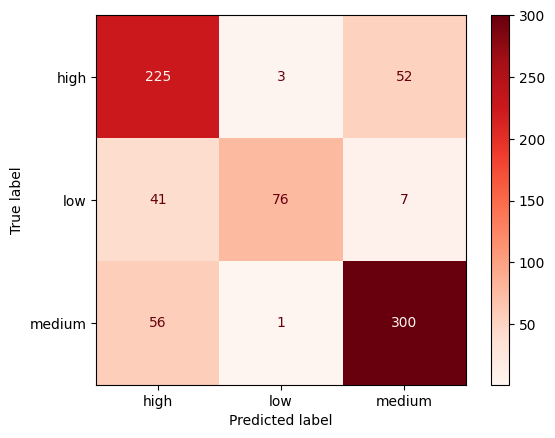


Classification Report:
              precision    recall  f1-score   support

        high       0.70      0.80      0.75       280
         low       0.95      0.61      0.75       124
      medium       0.84      0.84      0.84       357

    accuracy                           0.79       761
   macro avg       0.83      0.75      0.78       761
weighted avg       0.80      0.79      0.79       761



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Cog_Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.25, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

class ConformerModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(ConformerModel, self).__init__()
        self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
        self.maxpool1 = layers.MaxPooling1D(pool_size=2)
        self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
        self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
        self.layernorm1 = layers.LayerNormalization()
        self.feedforward = layers.Dense(128, activation='relu')
        self.layernorm2 = layers.LayerNormalization()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        attn_output = self.attention(x, x)
        x = self.layernorm1(attn_output + x)
        x = self.feedforward(x)
        x = self.layernorm2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = ConformerModel(num_classes=3)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Cog_Conformer_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('Cog_confusion_matrix_Conformer.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


#### 80 20

Dataset Shape: (3044, 420)
Columns: Index(['Name', 'Ch0_Hjorth_Mobility', 'Ch0_Hjorth_Complexity', 'Ch0_Mean',
       'Ch0_Std', 'Ch0_Kurtosis', 'Ch0_Skewness', 'Ch0_First_Diff_Mean',
       'Ch0_Second_Diff_Mean', 'Ch0_Max_Power',
       ...
       'Ch18_RBP_Beta', 'Ch18_RBP_Gamma', 'Ch18_Higuchi_FD',
       'Ch18_Petrosian_FD', 'Ch18_Wavelet_Energy_0', 'Ch18_Wavelet_Energy_1',
       'Ch18_Wavelet_Energy_2', 'Ch18_Wavelet_Energy_3',
       'Ch18_Wavelet_Energy_4', 'Label'],
      dtype='object', length=420)
Training Data Shape: (2435, 418, 1)
Testing Data Shape: (609, 418, 1)
Epoch 1/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.4660 - loss: 2.1333 - val_accuracy: 0.6305 - val_loss: 0.8358 - learning_rate: 0.0010
Epoch 2/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.6330 - loss: 0.8090 - val_accuracy: 0.6601 - val_loss: 0.7602 - learning_rate: 0.0010
Epoch 3/200
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.7060 - loss: 0.6728 - val_accuracy: 0.7356 - 

Model saved successfully.
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8026 - loss: 0.5103
Test Accuracy: 79.47%
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


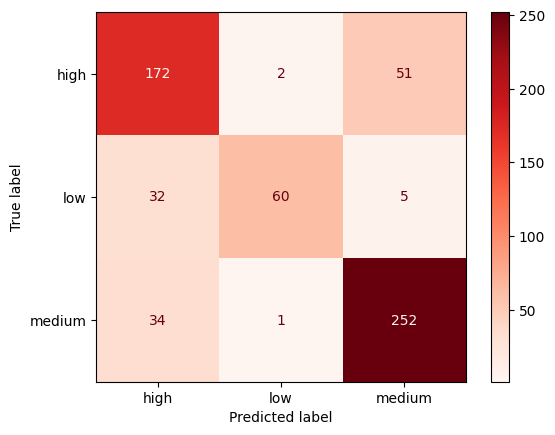


Classification Report:
              precision    recall  f1-score   support

        high       0.72      0.76      0.74       225
         low       0.95      0.62      0.75        97
      medium       0.82      0.88      0.85       287

    accuracy                           0.79       609
   macro avg       0.83      0.75      0.78       609
weighted avg       0.80      0.79      0.79       609



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

file_path = 'Cog_Normalized_Features.csv'
data = pd.read_csv(file_path)

print("Dataset Shape:", data.shape)
print("Columns:", data.columns)

X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

class ConformerModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(ConformerModel, self).__init__()
        self.conv1 = layers.Conv1D(64, kernel_size=3, activation='relu')
        self.maxpool1 = layers.MaxPooling1D(pool_size=2)
        self.conv2 = layers.Conv1D(128, kernel_size=3, activation='relu')
        self.maxpool2 = layers.MaxPooling1D(pool_size=2)
        self.attention = layers.MultiHeadAttention(num_heads=4, key_dim=128)
        self.layernorm1 = layers.LayerNormalization()
        self.feedforward = layers.Dense(128, activation='relu')
        self.layernorm2 = layers.LayerNormalization()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(64, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        attn_output = self.attention(x, x)
        x = self.layernorm1(attn_output + x)
        x = self.feedforward(x)
        x = self.layernorm2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = ConformerModel(num_classes=3)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-6)

model.fit(X_train, y_train, 
          epochs=200, batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

model.save('Cog_Conformer_EEG_Model.h5')
print("Model saved successfully.")

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

ConfusionMatrixDisplay(conf_matrix, display_labels=label_encoder.classes_).plot(cmap='Reds')
plt.savefig('Cog_confusion_matrix_Conformer.png')
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print("\nClassification Report:")
print(report)


## ML without syn data

### SVM

Classification Report:
              precision    recall  f1-score   support

        high       0.72      0.76      0.74       344
         low       0.97      0.62      0.75       141
      medium       0.80      0.87      0.83       429

    accuracy                           0.79       914
   macro avg       0.83      0.75      0.78       914
weighted avg       0.80      0.79      0.79       914



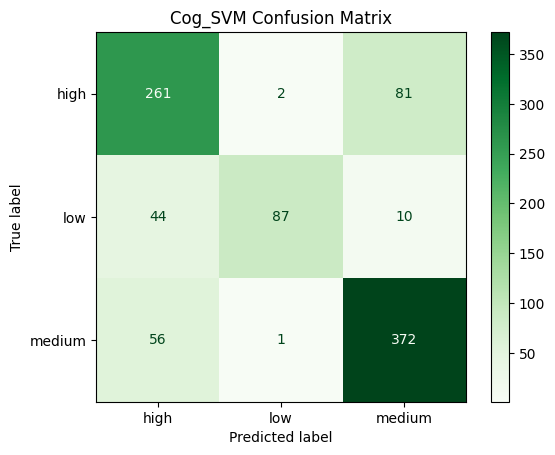

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

data = pd.read_csv('Cog_Normalized_Features.csv')
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=True)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(cmap='Greens')
plt.title("Cog_SVM Confusion Matrix")
plt.savefig("Cog_confusion_matrix_SVM.png")
plt.show()


### RANDOM FOREST

Classification Report:
              precision    recall  f1-score   support

        high       0.83      0.90      0.86       344
         low       0.95      0.64      0.76       141
      medium       0.93      0.96      0.94       429

    accuracy                           0.89       914
   macro avg       0.90      0.83      0.86       914
weighted avg       0.89      0.89      0.89       914



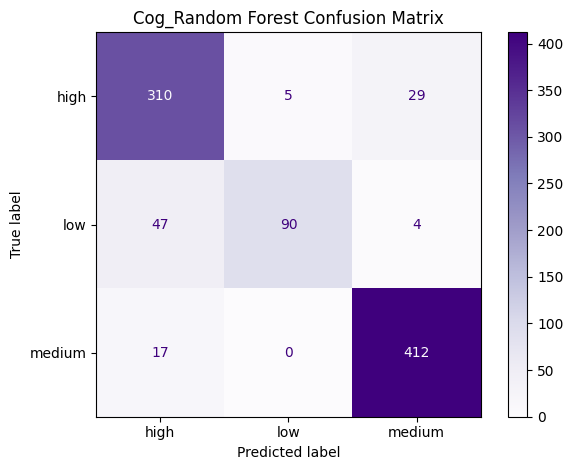

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

data = pd.read_csv('Cog_Normalized_Features.csv')
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Purples')
plt.title("Cog_Random Forest Confusion Matrix")
plt.tight_layout()
plt.savefig("Cog_confusion_matrix_RF.png")
plt.show()


### XG BOOST

In [35]:
%pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Program Files\Python310\python.exe -m pip install --upgrade pip' command.


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [14:30:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

        high       0.90      0.90      0.90       344
         low       0.89      0.84      0.87       141
      medium       0.95      0.97      0.96       429

    accuracy                           0.92       914
   macro avg       0.91      0.90      0.91       914
weighted avg       0.92      0.92      0.92       914



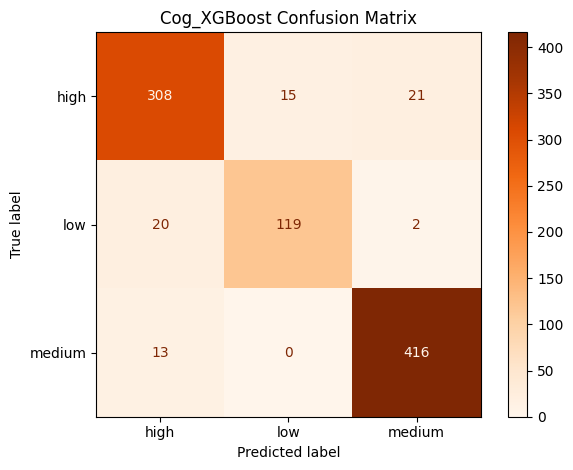

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import matplotlib.pyplot as plt

data = pd.read_csv('Cog_Normalized_Features.csv')
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

xgb_model = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    reg_alpha=0.1,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Oranges')
plt.title("Cog_XGBoost Confusion Matrix")
plt.tight_layout()
plt.savefig("Cog_confusion_matrix_XGBoost.png")
plt.show()


### KNN

Classification Report:
              precision    recall  f1-score   support

        high       0.64      0.74      0.69       344
         low       0.72      0.65      0.68       141
      medium       0.81      0.74      0.77       429

    accuracy                           0.73       914
   macro avg       0.72      0.71      0.71       914
weighted avg       0.73      0.73      0.73       914



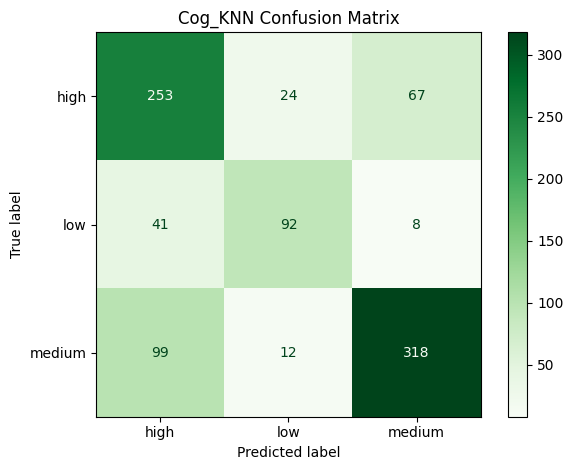

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

data = pd.read_csv('Cog_Normalized_Features.csv')
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Greens')
plt.title("Cog_KNN Confusion Matrix")
plt.tight_layout()
plt.savefig("Cog_confusion_matrix_KNN.png")
plt.show()


### CNN + LSTM + RANDOM FOREST

C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Cog_Classification Report:
              precision    recall  f1-score   support

        high       0.55      0.61      0.58       344
         low       0.84      0.43      0.57       141
      medium       0.64      0.68      0.66       429

    accuracy                           0.61       914
   macro avg       0.67      0.57      0.60       914
weighted avg       0.63      0.61      0.61       914



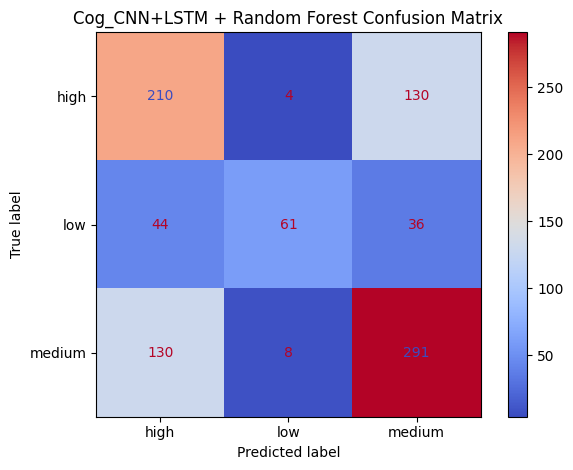

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

data = pd.read_csv('Cog_Normalized_Features.csv')
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

X_train_dl = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_dl = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

feature_model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.LSTM(64, return_sequences=False),
    layers.Flatten(),
    layers.Dense(128, activation='relu')
])

features_train = feature_model.predict(X_train_dl)
features_test = feature_model.predict(X_test_dl)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(features_train, y_train)

y_pred = rf_model.predict(features_test)

print("Cog_Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='coolwarm')
plt.title("Cog_CNN+LSTM + Random Forest Confusion Matrix")
plt.tight_layout()
plt.savefig("Cog_conf_matrix_CNN_LSTM_RF.png")
plt.show()


### XGBOOST + CNN

27/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\AroSamSay\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [14:30:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

        high       0.58      0.61      0.59       344
         low       0.71      0.38      0.49       141
      medium       0.66      0.72      0.69       429

    accuracy                           0.63       914
   macro avg       0.65      0.57      0.59       914
weighted avg       0.63      0.63      0.62       914



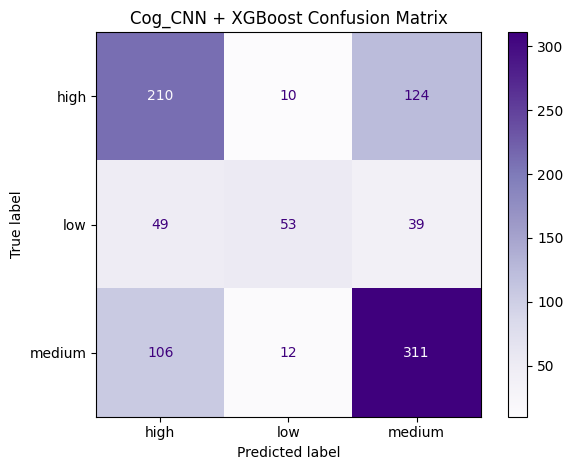

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models
import xgboost as xgb
import matplotlib.pyplot as plt

data = pd.read_csv('Cog_Normalized_Features.csv')
X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

cnn_model = models.Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation='relu')
])

features_train = cnn_model.predict(X_train_cnn)
features_test = cnn_model.predict(X_test_cnn)

xgb_model = xgb.XGBClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2,
    reg_alpha=0.1,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

xgb_model.fit(features_train, y_train)
y_pred = xgb_model.predict(features_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Purples')
plt.title("Cog_CNN + XGBoost Confusion Matrix")
plt.tight_layout()
plt.savefig("Cog_confusion_matrix_CNN_XGBoost.png")
plt.show()


## Graphs

### Boxplot / Violin plot

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.preprocessing import StandardScaler

# # Load the extracted features
# df = pd.read_csv('ExtractedFeatures.csv')

# # Select only numeric columns
# numeric_features = df.select_dtypes(include=['number'])

# # Standardize features
# scaler = StandardScaler()
# scaled_array = scaler.fit_transform(numeric_features)

# # Create a DataFrame from the scaled values
# scaled_df = pd.DataFrame(scaled_array, columns=numeric_features.columns)

# # Boxplot of scaled features
# plt.figure(figsize=(16, 8))
# sns.boxplot(data=scaled_df)
# plt.xticks(rotation=90)
# plt.ylim(-2, 2)
# plt.title("Boxplot of Standardized EEG Features")
# plt.tight_layout()
# plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'ExtractedFeatures.csv'

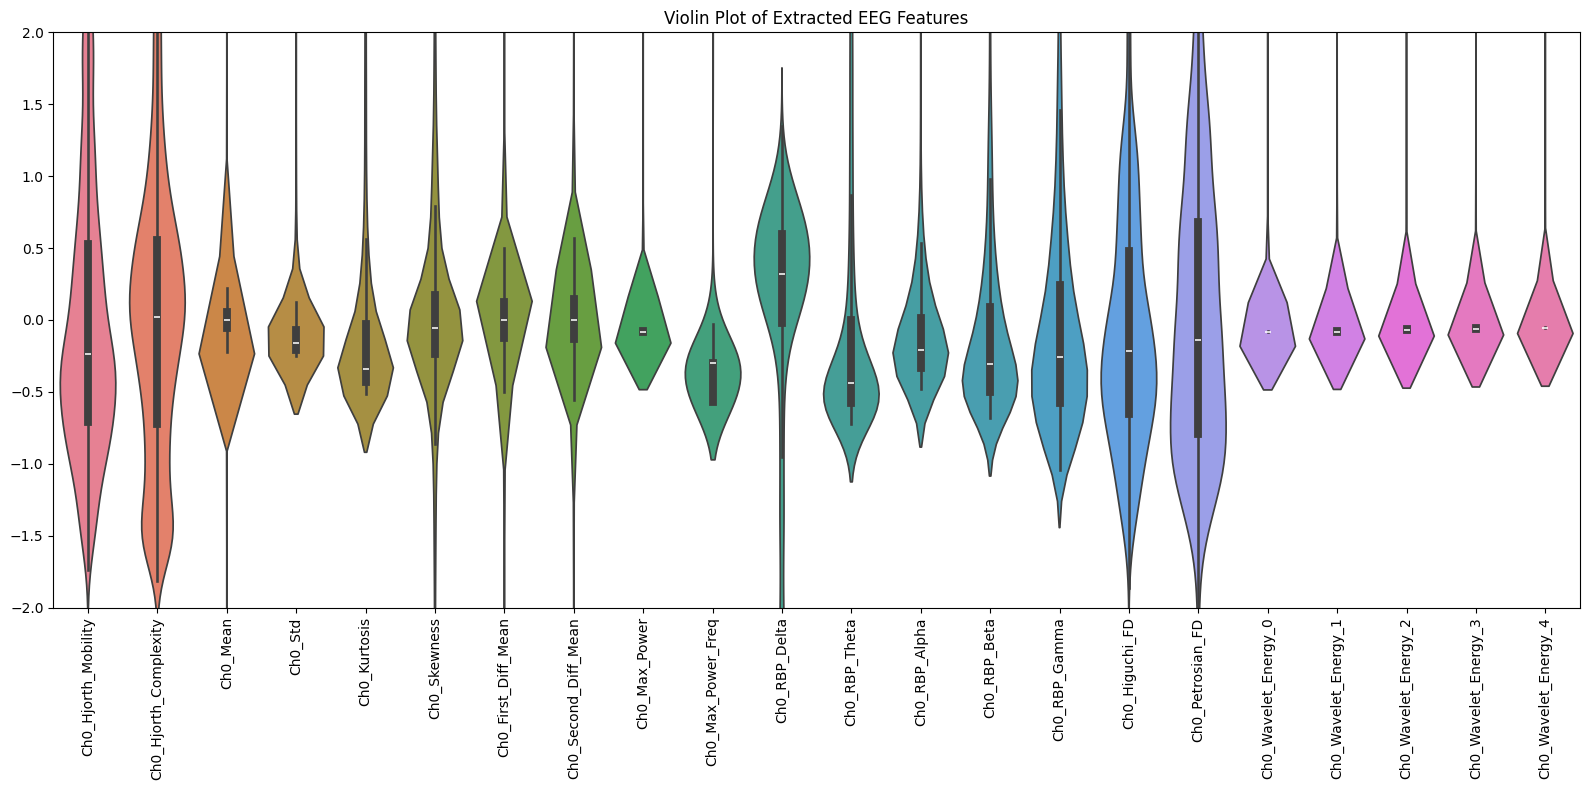

In [ ]:
# plt.figure(figsize=(16, 8))
# sns.violinplot(data=scaled_df)
# plt.xticks(rotation=90)
# plt.ylim(-2, 2)  
# plt.title("Violin Plot of Extracted EEG Features")
# plt.tight_layout()
# plt.show()


### Correlation Matrix(HeatMap)

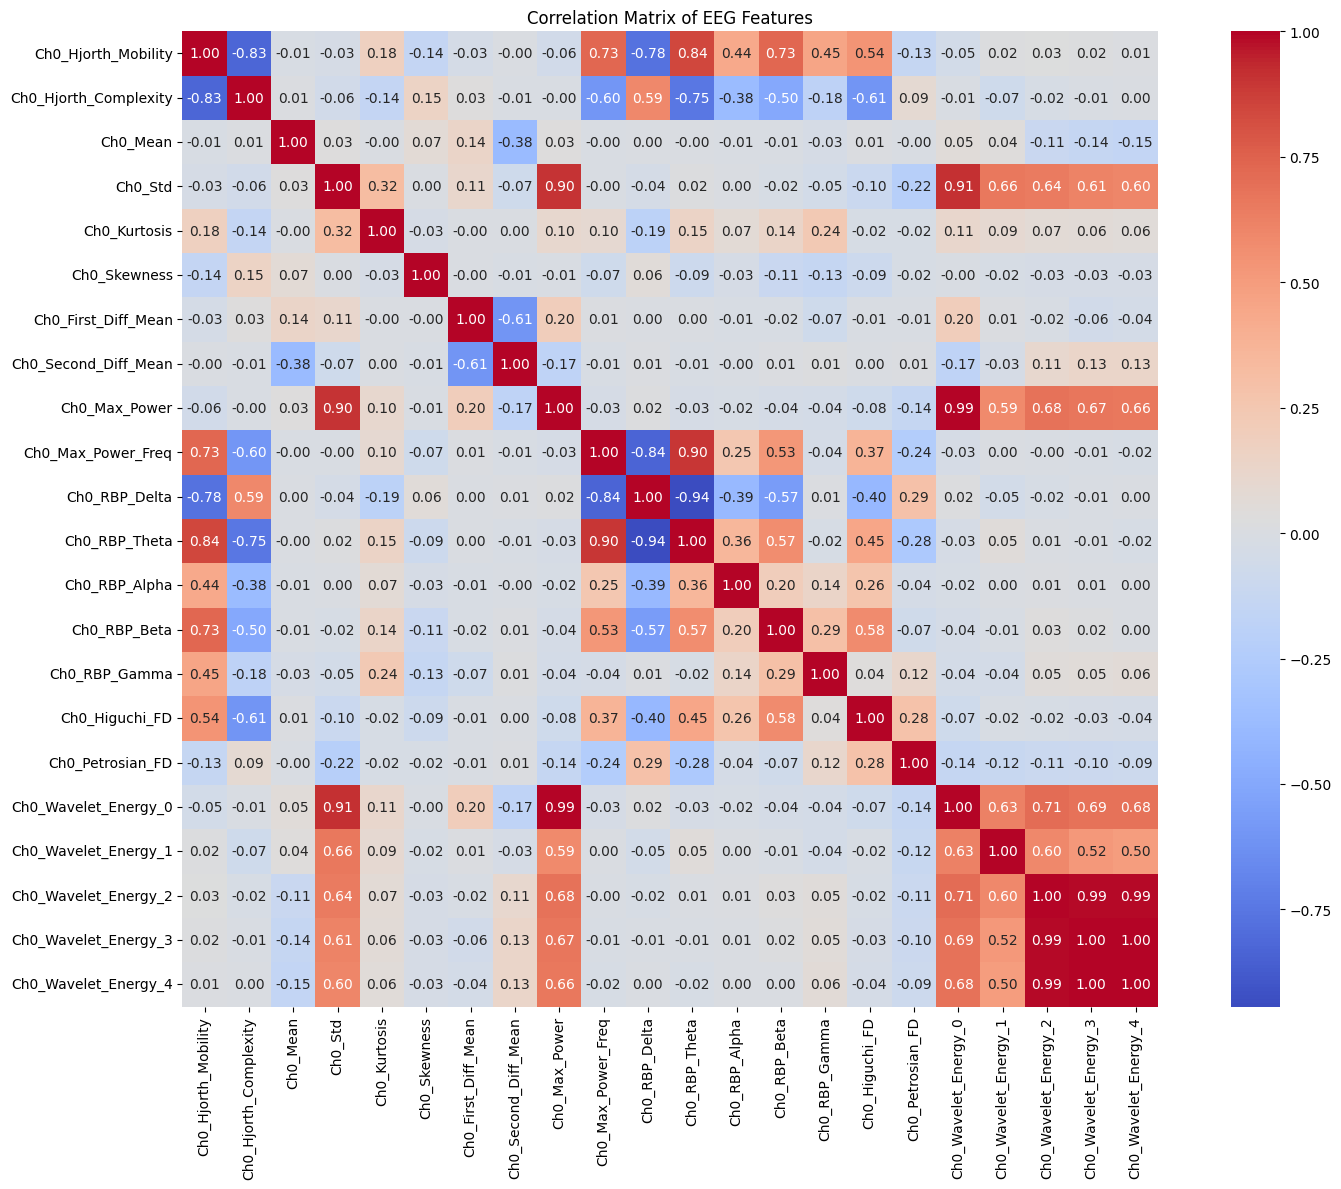

In [ ]:
# correlation_matrix = numeric_features.corr() 

# # Plotting the heatmap
# plt.figure(figsize=(16, 12))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
# plt.title("Correlation Matrix of EEG Features")
# plt.tight_layout()
# plt.show()


### Real vs Synthetic feature Distribution

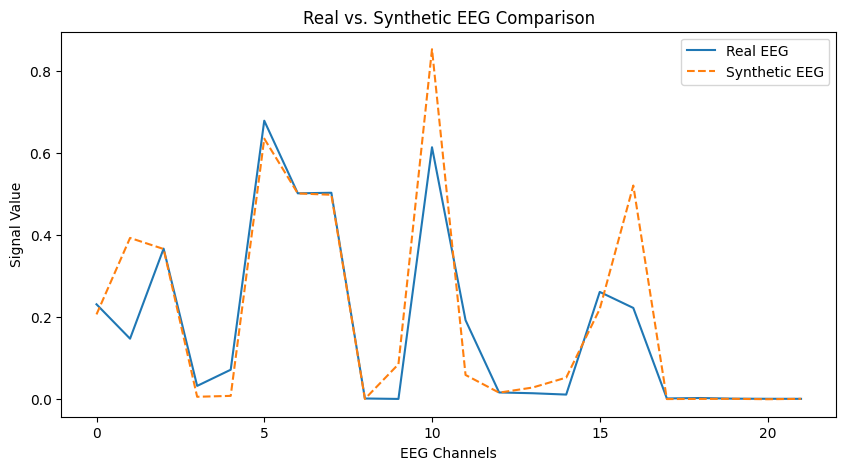

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# # Load real and synthetic EEG data
# real_data = pd.read_csv("Normalized_Features.csv")
# synthetic_data = pd.read_csv("Syn_data.csv")

# # Select a random real and synthetic sample
# real_sample = real_data.iloc[0, 1:-1].values  # First real EEG sample
# synthetic_sample = synthetic_data.iloc[0, 1:-1].values  # First synthetic EEG sample

# # Plot EEG signals for comparison
# plt.figure(figsize=(10, 5))
# plt.plot(real_sample, label="Real EEG", linestyle="-")
# plt.plot(synthetic_sample, label="Synthetic EEG", linestyle="--")
# plt.xlabel("EEG Channels")
# plt.ylabel("Signal Value")
# plt.title("Real vs. Synthetic EEG Comparison")
# plt.legend()
# plt.show()


### Model Accuracy and Loss Curves

Need to change the history component acc to the model and training

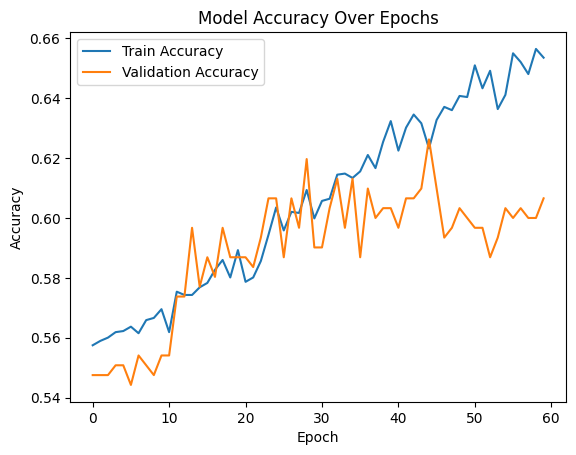

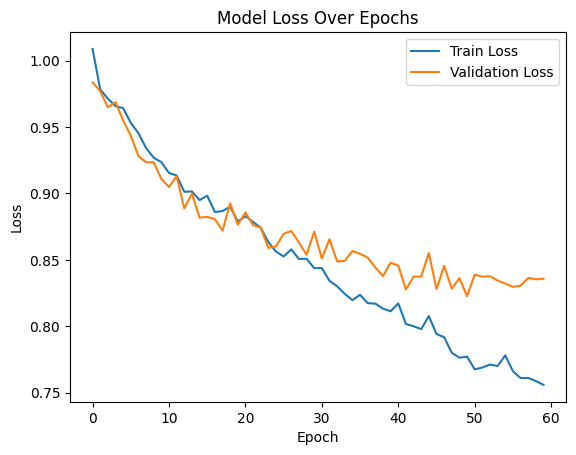

In [ ]:
# import matplotlib.pyplot as plt

# # Accuracy plot
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Loss plot
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss Over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


### ROC Curves (for each class)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


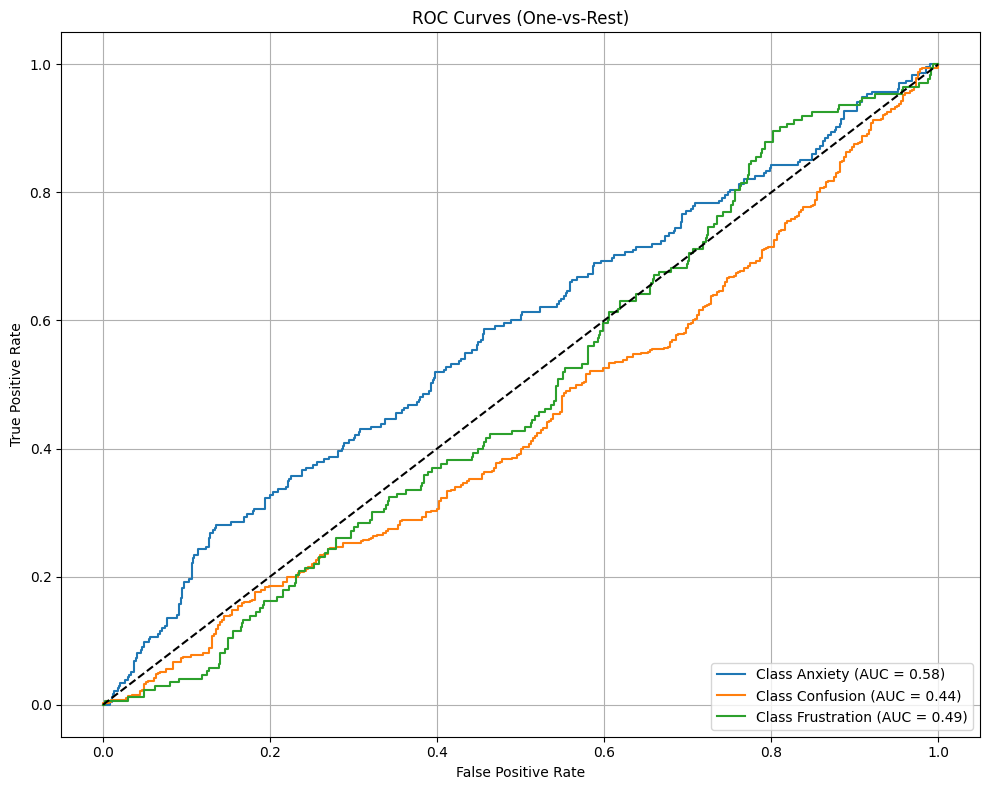

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model
# from sklearn.preprocessing import label_binarize, LabelEncoder
# from sklearn.metrics import roc_curve, auc
# from sklearn.model_selection import train_test_split

# # ---- STEP 1: Load and preprocess data ----
# df = pd.read_csv('Normalized_Features.csv')  # Replace with your actual file

# # Drop label column and ensure numeric input features
# X = df.drop(columns=['Label']).apply(pd.to_numeric, errors='coerce')
# X = X.fillna(0)  # Fill missing values if any

# # Encode labels
# y = df['Label']
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# # ---- STEP 2: Load trained model (.h5 file) ----
# model = load_model('CNN_EEG_Model.h5')  # Replace with your actual model filename

# # ---- STEP 3: Predict class probabilities ----
# y_score = model.predict(X_test)

# # ---- STEP 4: Binarize true labels for ROC calculation ----
# n_classes = y_score.shape[1]
# y_test_bin = label_binarize(y_test, classes=range(n_classes))

# # ---- STEP 5: Plot ROC Curves ----
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, label=f'Class {le.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], 'k--')
# plt.title("ROC Curves (One-vs-Rest)")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


### Precision-Recall Curves

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


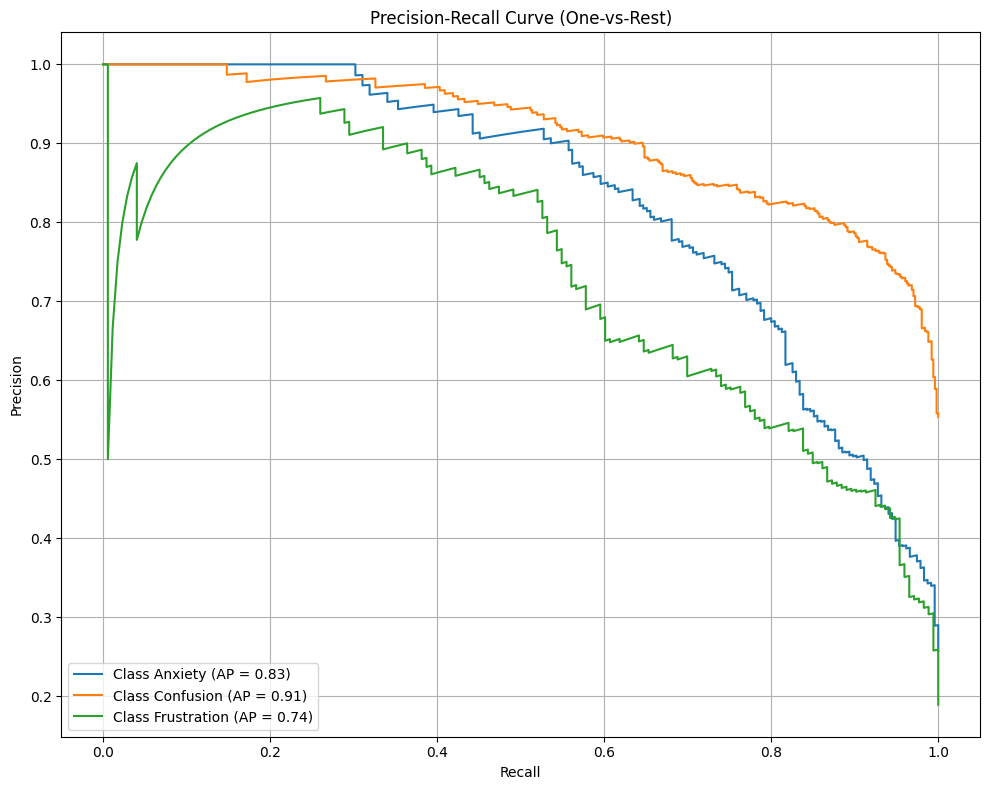

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from tensorflow.keras.models import load_model
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
# from sklearn.metrics import precision_recall_curve, average_precision_score

# # ---- STEP 1: Load and preprocess the data ----
# df = pd.read_csv('Normalized_Features.csv')  # Replace with your file path

# # Separate features and label
# X = df.drop(columns=['Label'], errors='ignore')
# y = df['Label']

# # Keep only numeric features (drop any non-numeric columns silently)
# X = X.select_dtypes(include=[np.number])

# # Handle missing values if any
# X = X.fillna(0)

# # Scale features (optional if already normalized, but useful to ensure consistency)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Encode string labels to integers
# le = LabelEncoder()
# y_encoded = le.fit_transform(y)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

# # ---- STEP 2: Load the trained model ----
# model = load_model('CNN_EEG_Model.h5')  # Replace with your model path

# # ---- STEP 3: Get predicted probabilities ----
# y_score = model.predict(X_test)

# # ---- STEP 4: Binarize test labels for multiclass PR curve ----
# n_classes = y_score.shape[1]
# y_test_bin = label_binarize(y_test, classes=range(n_classes))

# # ---- STEP 5: Plot Precision-Recall Curves ----
# plt.figure(figsize=(10, 8))
# for i in range(n_classes):
#     precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
#     ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
#     class_name = le.inverse_transform([i])[0]  # Convert encoded label back to original
#     plt.plot(recall, precision, label=f'Class {class_name} (AP = {ap:.2f})')

# plt.title("Precision-Recall Curve (One-vs-Rest)")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.legend(loc='lower left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


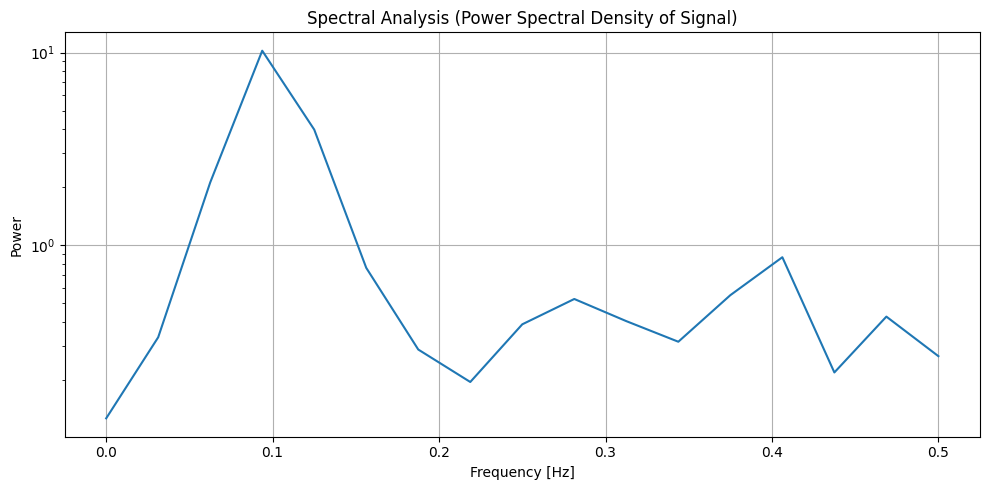

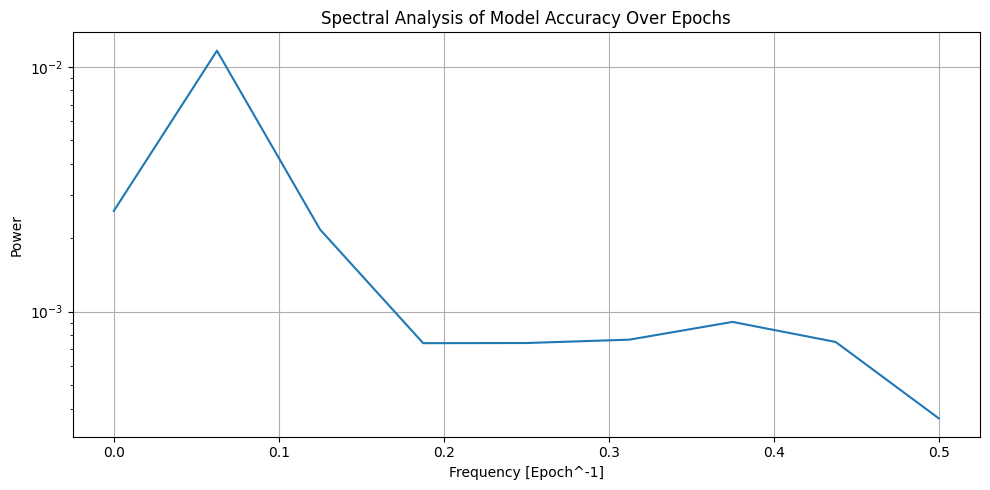

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# -----------------------------
# PART 1: Simulate a sample signal
# -----------------------------
np.random.seed(0)

# Simulate a noisy sinusoidal signal (e.g., fake EEG or training metric)
time = np.arange(0, 100)
signal = np.sin(2 * np.pi * 0.1 * time) + 0.5 * np.random.randn(100)

# -----------------------------
# PART 2: Spectral Analysis using Welch’s method
# -----------------------------
frequencies, power = welch(signal, fs=1.0, nperseg=32)

# -----------------------------
# PART 3: Plot Power Spectral Density
# -----------------------------
plt.figure(figsize=(10, 5))
plt.semilogy(frequencies, power)
plt.title("Spectral Analysis (Power Spectral Density of Signal)")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------
# BONUS: Apply to Model Accuracy (if available)
# -----------------------------
# Example: Simulated model accuracy over 60 epochs
simulated_accuracy = 0.5 + 0.05 * np.sin(2 * np.pi * 0.05 * np.arange(60)) + 0.02 * np.random.randn(60)

frequencies_acc, power_acc = welch(simulated_accuracy, fs=1.0, nperseg=16)

plt.figure(figsize=(10, 5))
plt.semilogy(frequencies_acc, power_acc)
plt.title("Spectral Analysis of Model Accuracy Over Epochs")
plt.xlabel("Frequency [Epoch^-1]")
plt.ylabel("Power")
plt.grid(True)
plt.tight_layout()
plt.show()
